# Algoritmos heurísticos para la resolución de un problema de carga de camiones





Correspondiente con el Trabajo de Fin de Grado de Ingeniería informática

Autor:
* Rubén Castillo Carrasco

Tutor:
* Francisco Parreño Torres

Curso : 2022/2023

Intensificación en Computación

Índice de contenidos
1. Introducción
2. Entrada de datos 
3. Respresentacion gráfica
4. Implementación de las heuristicas
5. Implementación de algoritmos metaheuristicos
6. Comparativa de los resultados 

## 2. Entrada de datos


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random 
import random
import scipy.stats as st
import copy
import seaborn as sns
import matplotlib.pyplot as plt

### 2.1 Entrada de la instancia de camión 

En primer lugar, se carga en memoria el valor del camion que se utiliazará en el experimento, que en este caso se ha decidido que sea el primero del fichero de la primera instancia del problema propuesto en el challenge roadef, que se encuentra almacenado en un fichero csv. Para ello, haciendo uso de la libreria pandas se carga en un dataframe y se imprime por pantalla para ver sus valores

In [3]:
df_truck = pd.read_csv('input_trucks.csv',sep=';')
truck= df_truck.loc[0,["Length","Width","Height","Max weight","EMmm","EMmr","EJhr","EJeh","EM","EJcr","CM","CJfc","CJfh","CJfm"]]
print(truck)

Length           14940
Width             2500
Height            2950
Max weight       24000
EMmm             12000
EMmr             31500
EJhr              7630
EJeh              1670
EM            7300,000
EJcr              2350
CM            7808,000
CJfc              1040
CJfh              3330
CJfm              3800
Name: 0, dtype: object


Se puede observar que, en la base de datos de la que se ha extraido los datos estos se han hecho usando la coma como separador decimal en lugar del punto. Antes de corregirlo, para detectar otros posibles errores, se extraen los tipos que tienen los datos cargados

In [4]:
#para observar los tipos
columnas = truck.keys() #Iterable de las variables qeu almacena
tipos = {name:type(truck[name]) for name in columnas}
for ent in tipos:
    print(ent," -> \t",tipos[ent])

Length  -> 	 <class 'numpy.int64'>
Width  -> 	 <class 'numpy.int64'>
Height  -> 	 <class 'numpy.int64'>
Max weight  -> 	 <class 'numpy.int64'>
EMmm  -> 	 <class 'numpy.int64'>
EMmr  -> 	 <class 'numpy.int64'>
EJhr  -> 	 <class 'numpy.int64'>
EJeh  -> 	 <class 'numpy.int64'>
EM  -> 	 <class 'str'>
EJcr  -> 	 <class 'numpy.int64'>
CM  -> 	 <class 'str'>
CJfc  -> 	 <class 'numpy.int64'>
CJfh  -> 	 <class 'numpy.int64'>
CJfm  -> 	 <class 'numpy.int64'>


En principio, el unico error encontrado es el anterior, por lo que se pasa a hacer castings de las variables en formato String a numericos con el separador decimal corregido

In [5]:
for ent in tipos:
    if(tipos[ent]==type('str')):
        truck[ent]=truck[ent].replace(',', '.')
truck=truck.astype(float)



Por ultimo, se compureba que el casting se ha llevado a cabo de forma correcta

In [6]:
columnas = truck.keys() #Iterable de las variables qeu almacena
tipos = {name:type(truck[name]) for name in columnas}
for ent in tipos:
    print(ent," -> \t",tipos[ent])

Length  -> 	 <class 'numpy.float64'>
Width  -> 	 <class 'numpy.float64'>
Height  -> 	 <class 'numpy.float64'>
Max weight  -> 	 <class 'numpy.float64'>
EMmm  -> 	 <class 'numpy.float64'>
EMmr  -> 	 <class 'numpy.float64'>
EJhr  -> 	 <class 'numpy.float64'>
EJeh  -> 	 <class 'numpy.float64'>
EM  -> 	 <class 'numpy.float64'>
EJcr  -> 	 <class 'numpy.float64'>
CM  -> 	 <class 'numpy.float64'>
CJfc  -> 	 <class 'numpy.float64'>
CJfh  -> 	 <class 'numpy.float64'>
CJfm  -> 	 <class 'numpy.float64'>


A continuacion con los datos transformados, se cambia a una estructura de datos que facilite su manipulacion, usando una tupla donde el primer elemento se correspone con las dimensiones, formado por una tupla de la forma $ (dim_x,dim_y,dim_z) $, y por otro lado el segundo elemento de la tupla almacena las restricciones de masa en un diccionario, donde la key consiste en el nombre de la restriccion

In [7]:
dim  = truck.loc[["Length","Width","Height"]]
dim = dim.tolist()
rest_masa = truck.loc[["Max weight","EMmm","EMmr","EJhr","EJeh","EM","EJcr","CM","CJfc","CJfh","CJfm"]]
rest_masa = rest_masa.to_dict()
truck = (dim,rest_masa)
print(truck)

([14940.0, 2500.0, 2950.0], {'Max weight': 24000.0, 'EMmm': 12000.0, 'EMmr': 31500.0, 'EJhr': 7630.0, 'EJeh': 1670.0, 'EM': 7300.0, 'EJcr': 2350.0, 'CM': 7808.0, 'CJfc': 1040.0, 'CJfh': 3330.0, 'CJfm': 3800.0})


### 2.2 Entrada de las instancias de palets


### 2.2.1 Instancias del challenge roadef

Primera aproximacion: obtención de los palets mediante uno de los csv proporcionados por el challenge Roadef
En primer lugar, dado que la experimentacion se basa en el challenge, se toman las instancias de palets ofrecidas en una instancia de problema. Para ello, al igual que con el camion se extrae de un fichero csv, cargando su contenido en un dataframe, se extraen unicamente los atributos necesarios y se comprueban la cantidad de instancias del problema.


In [8]:
df_items = pd.read_csv('input_items.csv',sep=';',decimal=",")
df_items= df_items.loc[:,["Item ident","Supplier code","Length","Width","Height","Weight","Forced orientation"]]
print("La cantidad de instancias del dataset es de",df_items.shape[0])

La cantidad de instancias del dataset es de 15867


Se tiene que la cantidad de instancias es superior a 15.000, algo que impediria resolver este problema mediante algoritmos como  backtracking, ya que no seria resoluble en una cantidad de tiempo aceptable. Tras esto, se pasa a observar las 5 primeras instancias.

In [53]:
df_items.head(5)

,Item ident,Supplier code,Length,Width,Height,Weight,Forced orientation
0,0090018000_27022023000001,62069600,1600.0,1200.0,975.0,190.00,0
1,0090018000_27022023000002,62067900,1200.0,1000.0,459.0,47.02,0
2,0090018000_27022023000003,62067900,1200.0,1000.0,1057.0,101.55,0
3,0090018000_27022023000004,62059600,1200.0,1000.0,930.0,413.58,0
4,0090018000_27022023000005,62067900,1200.0,1000.0,750.0,106.03,0


Una vez hecho esto, se usa el metodo `info` para descubrir el tipo en el que se cargan las varaibles, por si es necesario realizar alguna modificacion o casting sobre alguna de ellas.

In [10]:
df_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15867 entries, 0 to 15866
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Item ident          15867 non-null  object 
 1   Supplier code       15867 non-null  int64  
 2   Length              15867 non-null  int64  
 3   Width               15867 non-null  int64  
 4   Height              15867 non-null  int64  
 5   Weight              15867 non-null  float64
 6   Forced orientation  15867 non-null  object 
dtypes: float64(1), int64(4), object(2)
memory usage: 867.9+ KB


Para las variables de tipo numerico, se usa el metodo `describe` para obtener algo de información acerca de ellas, como el valor medio de los atributos o los extremos. Cabe destacar que el palet de mayor altura, con 2.35 m de alto apenas alcanza el 80% de la altura total del camión, por lo que los valorer óptimos del problema en este caso nunca superaran el 80% de su capacidad.

In [11]:
df_items.describe()

,Supplier code,Length,Width,Height,Weight
count,1.586700e+04,15867.000000,15867.000000,15867.000000,15867.000000
mean,5.564633e+07,1423.797819,1081.428436,887.069641,221.525286
std,1.353360e+07,319.450783,141.345384,246.836424,155.025966
min,2.893800e+06,780.000000,570.000000,259.000000,16.670000
25%,6.205570e+07,1200.000000,1000.000000,750.000000,129.000000
50%,6.205960e+07,1200.000000,1000.000000,930.000000,174.305000
75%,6.206790e+07,1600.000000,1200.000000,975.000000,272.592000
max,6.206960e+07,2400.000000,1600.000000,2350.000000,1105.440000


En cuanto a la variable de las orientaciones permitidas, como se vió en la definición del problema, solo se acepta o bien orientacion fija o widthwise, donde la dimension x (anchura) del palet debe coincidir con la dimensión x del camión, o la orientación no forzada o none, que permite colocar la dimension x (anchura) del palet o bien en el eje x o y del camión, y su dimensión y (longitud) en el eje y o x del camión respectivamente

In [12]:
print(df_items["Forced orientation"].unique())

['none' 'widthwise']


Para facilitar el uso de la variable, se reemplaza none por el valor entero 0 y widthwise por 1

In [13]:
df_items["Forced orientation"]= df_items["Forced orientation"].replace(["none"],0)
df_items["Forced orientation"]= df_items["Forced orientation"].replace(["widthwise"],1)
df_items["Forced orientation"].dtype

dtype('int64')

Por ultimo se hace casting de algunas variables a float para evitar posibles errores

In [14]:
df_items["Length"]=df_items["Length"].astype(float)
df_items["Width"]=df_items["Width"].astype(float)
df_items["Height"]=df_items["Height"].astype(float)
df_items.dtypes

Item ident             object
Supplier code           int64
Length                float64
Width                 float64
Height                float64
Weight                float64
Forced orientation      int64
dtype: object

Se comprueban que los cambios se han realizado de forma correcta

In [15]:
df_items.head()

,Item ident,Supplier code,Length,Width,Height,Weight,Forced orientation
0,0090018000_27022023000001,62069600,1600.0,1200.0,975.0,190.00,0
1,0090018000_27022023000002,62067900,1200.0,1000.0,459.0,47.02,0
2,0090018000_27022023000003,62067900,1200.0,1000.0,1057.0,101.55,0
3,0090018000_27022023000004,62059600,1200.0,1000.0,930.0,413.58,0
4,0090018000_27022023000005,62067900,1200.0,1000.0,750.0,106.03,0


Dado que una de la variable que optimiza la funcion de valor es el volumen, obtenible a partir de la altura del pale, se pasa a estudiar si realmente las instancias de palets tienen valores de altura distintos, lo que permitirá evaluar realmente como de buena es la solucion obtenida por el problema.

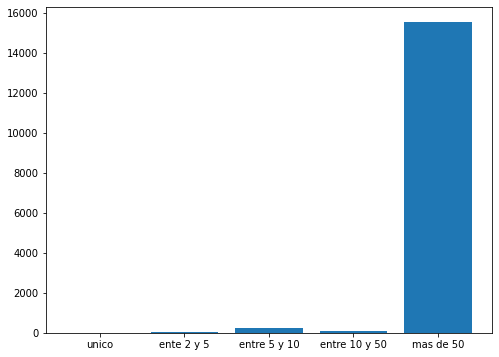

In [16]:
(elem,veces)=np.unique(df_items["Height"],return_counts=True)

unico = sum(1 for i in veces if i == 1)
de_2_a_5 = sum(i for i in veces if (i>1 and i<=10))
de_5_a_10= sum(i for i in veces if (i>10 and i<=50))
de_10_a_50 = sum(i for i in veces if (i>50 and i<=100))
mas_50 = sum(i for i in veces if i > 100)
times = [unico,de_2_a_5,de_5_a_10,de_10_a_50,mas_50]
labels = ["unico","ente 2 y 5","entre 5 y 10","entre 10 y 50", "mas de 50"]
plt.figure(figsize=(8, 6)) 
plt.bar(labels, times)

plt.show()

Como se puede observar, el atributo alturas en la gran mayoria de los casos se repite, y dado que este atributo esta implicado de forma directa al resultado de la funcion de evaluacion, se ha decidido implementar una funcion que genere instancias más variadas que si que permitan estudiar como se comporta cada algoritmo a implementar

### 2.2.2 Alternativa a la entrada propuesta: generador de palets
Como se ha podido obervar, los valores de las dimensiones de pales no son muy variados, lo que hace que para poder evaluar los resultados del problema se puedan cometer errores. Para evitar esto, se ha decidido implementar un generador de pales que, en funcion de una serie de parametros indicados sea capaz de generar una serie de datos que permitan evaluar el comportamiento de los algoritmos.

El metodo `generaInstancias` devuelve un dataset de palets tomando como parametros el numero de clientes y la cantidad de palets a generar.

En este caso, los valores de los atributos generados se ha decidido que sigan las sigueintes distribuciones:
- __Altura__ (o dimensión z): se calcula en función de la altura del camión de entrada, en este caso usando una distribución gaussiana, de tal forma que la media se situe en el 60% de la altura del camión y con una varianza que implique que la porbabilidad de que el valor generado sea mayor o igual que la altura del camion sea del 5%. Para ello, tomando como entrada la altura del camion

- __Anchura__ (o dimensión x): en este caso se usa una distribución gaussiana centrada en la mitad del eje y del camion,

- __Longitud__ (o dimensión y): se calcula en función de una distribución gaussiana, también a partir del eje y del camión, pero en este caso centrada en un 80% del valor de este. 

- __Peso__: en este caso se usa una distribuión uniforme, que devuelve valores en el intervalo [0-100], de tal forma que en general solo unos pocos podrán causar que se incumpla alguna de las restricciones de masa.

- __Orientación permitida__: se generan de forma aleatoria teneiendo en cuenta que $P(or="none")=0.2, P(or="widthwise")=0.8$, de tal forma que la mayoria presenten orientación fija.

- __Cliente__: valor aleatorio entre 1 y el numero de clientes a crear, de tal forma que los identificadores de los clientes tendrán un valor entero entre 1 y n, siendo n el numero de clientes a generar.

Para comprobar como funcionan los metodos en python, primeramente se prueba su funcionamiento con altura 100, por lo que la altura media de la distribución sera 60, y el 95% de los palés tengan algura menor o igual a 100. Esto se halla mediante el método del paquete scipy.stats `norm.ppf`, que devuelve el valor de z que deja el 95% fuera en la distribución. Con este, se calcula la varianza y, al conocer ya la media, se conoce la distribución gaussiana que genera los datos.

In [17]:
dz = 100
media_altura = 0.6*dz
zval = st.norm.ppf(.95)
# Con esto se tiene que P(z<(media_altura-dz)/var) = 0.95 -> (media_altura-dz)/var = st.norm.ppf(.95)
# (media_altura-dz)/var = 1.644 -> con esto se puede calcular la desviación que permite esto
var = (dz-media_altura)/zval
zdim = abs(random.normalvariate(media_altura,var)) 
print(f"El valor de la varianza queda tal que {var} y un valor generado por la distribución es {zdim}")

El valor de la varianza queda tal que 24.318273276470766 y un valor generado por la distribución es 110.38405975012532


In [18]:
def generaInstancias(cantidad,clientes,dim_camion=(10.,10.,10.),seed=1000):
    df = pd.DataFrame({"Item ident":[],"Supplier code":[],"Length":[],"Width":[],"Height":[],"Weight":[],"Forced orientation":[]})
    
    _,dy,dz = dim_camion
    random.seed(seed)
    
    for i in range(cantidad):
        #Indice usado como identificador, de tal forma que se conserve el id al reordenar el dataframe para la funcion de seleccion
        id_pale=i
        
        # Calculo del atributo cliente
        cliente = int(random.random()*clientes + 1) #Id de cliente aleatorio entre 1 y numero de clientes
        
        # Calculo de las dimensiones x e y
        xdim = abs(random.normalvariate(dy*0.8,dy/8)) 
        ydim =  abs(random.normalvariate(dy*0.5,dy/8)) 
        
        # Calculo de la altura
        # Se usa st.norm.ppf para obtener de una distribucion nomal a partir del p-valor el zscore que lo obtiene
        media_altura = 0.6*dz
        zval = st.norm.ppf(.95)
        # Con esto se tiene que P(z<(media_altura-dz)/var) = 0.95 -> (media_altura-dz)/var = st.norm.ppf(.95)
        # (media_altura-dz)/var = 1.644 -> con esto se puede calcular la desviación que permite esto
        var = (dz-media_altura)/zval
        zdim = abs(random.normalvariate(media_altura,var)) 
        
        
        #Calculo del peso
        peso = abs(np.random.randint(20,50)) 
        
        # Calculo de la orientacion
        aleat = random.random()
        if(aleat<=0.2):
            #0 representa orientacion fija
            orien = 0
        else:
            #1 representa orientacion variable
            orien = 1
                                                        
        df.loc[i] = [id_pale,cliente,xdim,ydim,zdim,peso,orien]
        df = df.astype({'Item ident':'int','Supplier code':'int','Forced orientation':'int'})
    return df

In [19]:
df=generaInstancias(10,5)
df

,Item ident,Supplier code,Length,Width,Height,Weight,Forced orientation
0,0,4,8.404253,4.407450,12.670802,28.0,0
1,1,4,7.430422,3.092090,3.903528,41.0,0
2,2,5,7.950117,5.785968,8.617742,49.0,1
3,3,5,8.478036,6.070865,8.585334,47.0,0
4,4,2,6.865948,3.487192,4.412297,43.0,1
5,5,2,8.352323,2.841427,8.727270,22.0,1
6,6,5,8.572578,4.444161,2.308517,35.0,1
7,7,2,8.974378,4.138133,6.454156,29.0,1
8,8,5,7.886949,5.967257,0.445754,43.0,0
9,9,1,7.369955,3.750290,6.653570,45.0,1


La gáfica que muestra como se distribuyen los valores de la altura es la siguiente, teniendo en cuenta de nuevo que $P(h_{pale}>h_{camion})=0.95$ y que $\mu{_h}=0.6\cdot h_{camion}$

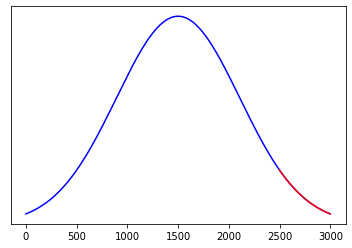

In [20]:
import math
altura_camion = 2500
media_altura = 0.6*altura_camion

#Nº de valores usados para calcular la funcion de la gaussiana para representarla de forma gráfica
n_intervalos = 10000

#Se calcula la varianza
zval = st.norm.ppf(.95)
# Con esto se tiene que P(z<(media_altura-dz)/var) = 0.95 -> (media_altura-dz)/var = st.norm.ppf(.95)
# (media_altura-dz)/var = 1.644 -> con esto se puede calcular la desviación que permite esto
var = (altura_camion-media_altura)/zval

#Lista de valores sobre el que se calcula el valor de la gaussiana
x = np.linspace(0,1.2*altura_camion,(n_intervalos))
prob = st.norm.pdf(x, media_altura, var)
plt.plot(x,prob , color = 'blue')

#En rojo se marcan los que no entran en el pale
non_valid = np.linspace(altura_camion,1.2*altura_camion,int((n_intervalos*0.05)))
p_non_valid = st.norm.pdf(non_valid, media_altura, var)

plt.plot(non_valid,p_non_valid , color = 'red')

plt.yticks([]) 
plt.show()

En cuanto a la distribución que se tiene para calcular tanto el largo como el ancho, se conoce tanto la media como la varianza, donde se toma que $\mu = 0.6\cdot L_x \ \ \  y \ \ \ \sigma = L_x/8$, de tal forma que la cota que contiene el 95% de los valores en este caso es , por lo que la distribución solo pasará este valor. Esto se puede observar en la distribución inferior.

El valor que supera al 95% de los generados por la distribucion de anchura es el  1183.179889893198


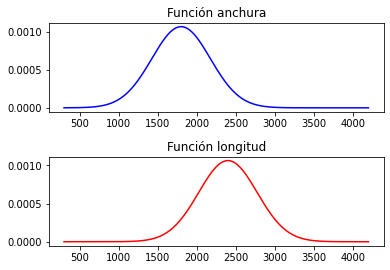

In [21]:
# Valor del la anchura del camion (dimension y)
anchura = 3000


# Equivalente a P(Z<=(mean-value)/var)=0.95
zval = st.norm.ppf(.95)
# A partir del anterior, dado que se tiene que zval = (mean - value)/varianza, se calcula la incognita value
value = anchura*0.6 - zval*(anchura/8)

print("El valor que supera al 95% de los generados por la distribucion de anchura es el ",value)

# Representacion de la distribución de anchura (dim x)
x = np.linspace(anchura*0.1,anchura*1.4,1000)
prob = st.norm.pdf(x, anchura*0.6, anchura/8)


fig, (ax1, ax2) = plt.subplots(2, 1, sharex=False)
fig.subplots_adjust(hspace=0.5, top=0.9)  # ajuste de espaciado y tamaño

ax1.plot(x,prob , color = 'blue')
ax1.set_title('Función anchura')


# Representacion de la distribución de anchura (dim x)
prob2 = st.norm.pdf(x, anchura*0.8, anchura/8)
#plt.subplot(2, 1, 2)  # 2 filas, 1 columna, primera figura
ax2.plot(x,prob2 , color = 'red')
ax2.set_title('Función longitud')
    

plt.show()

## 3. Represenación gráfica

Para poder evaluar las soluciones obtenidas por cada uno de los algoritmos de forma sencilla, y a su vez poder comprobar si las restricciones de forma rápida, se ha implementado un algoritmo que dibuje una solución pasada por parámetro.

Esta se ha implementado haciendo uso de la libreria `turtle`, una libreria preinstalada en python capaz de generar un lienzo sobre el que realizar dibujos.

La entrada a este método, 

In [22]:
from screeninfo import get_monitors
def anchuraPantalla():
    for i,m in enumerate(get_monitors()):
        anchura,altura = m.width,m.height
        print("La definicion del monitor",i+1 ,"es de",m.width,"x",m.height)
    return anchura

In [23]:
a = anchuraPantalla()

La definicion del monitor 1 es de 1366 x 768


In [24]:
import turtle
import random
def dibuja(camion,sol,df_items,anchuraPantalla):
    lapiz = turtle.Turtle()
    lapiz.speed(0) #Velocidad de dibujado instantanea
    lapiz.penup()
    
    #Se obtienen las dimensiones del camion para hallar la escala
    c_dimensiones  = camion[0]
    c_x,c_y,c_z = c_dimensiones 
    escala = (2* anchuraPantalla/3)/c_x #Se elige aquella escala que permita ocupar al ancho del camion 2/3 de la pantalla
    #print(f"El ancho del camion es de {c_x} y las dim {2*anchuraPantalla/3} por lo que la escala es {escala}")
    
    #Valor del pixel en pantalla para el origen de coordenadas O(0,0) del camion
    origen_x= -1*anchuraPantalla/3
    origen_y = -(c_y*escala)/2
    origen = (origen_x,origen_y)#Punto en la pantalla que se corresponde con el O(0,0) del camion
    
    #print(f"Los origenes son las coordenadas {(origen_x,origen_y)} y el fin {(origen_x+c_x*escala,origen_y+c_y*escala)}")
        
    #El lapiz de coloca en O(0,0) y se comienza a dibujar
    lapiz.goto(origen_x,origen_y)
    lapiz.pendown()
    lapiz.width(4)
    
    #Dibuja el camion de negro
    for i in range(2): 
        lapiz.forward(c_x*escala) #Se dibuja el valor de longitud_x del camion
        print(lapiz.pos()) #Se giran 90º
        lapiz.left(90)
        lapiz.forward(c_y*escala)
        lapiz.left(90)
        #print(lapiz.pos()) 
    lapiz.penup()
    lapiz.width(2)
    
    
    colors = ["red","blue","orange","pink","green","purple","aquamarine","beige","brown","chartreuse","coral","crimson","darkgreen"] #Lista de colores para cada cliente
    clientes={} #Diccionario de colores para cada cliente
    nclientes = 0 #Contador de los clientes encontrados
    

    for p in sol:
        if(p!=0 and p!=None):#Si para la posicion hay un pale colocado
            identificador = p[0]
            pale = df_items.loc[df_items["Item ident"]==identificador,:].iloc[0].tolist()
            #pale = df_items.loc[identificador,:].to_numpy().tolist()[0]
            dx,dy = pale[2:4]
            posx,posy=p[1]
            orient = p[2]
            
            if(orient==1):
                dx,dy=dy,dx
            
            dim=(dx,dy) #Dimensiones del pale
            pos=(posx,posy)#posicion de colocacion
            #print(pos)
            cliente=pale[1]
            
            #Si el cliente ya ha aparecido, se usa su color
            if(cliente in clientes):
                color = clientes[cliente]
                
            #Si no ha aparecido, se genera un color y se guarda en el diccionario para porximos pales del cliente
            else:
                color = colors[nclientes%len(colors)]
                clientes[cliente]=color
                nclientes+=1

            lapiz.fillcolor(color)
            lapiz.begin_fill()
            
            #Se usa el metodo auxiliar para obtener el valor de las coordenadas en pantalla
            lapiz.goto(puntoAEscala(origen,escala,pos))
            #print("Viajo a ",(puntoAEscala(origen,escala,pos)))
            lapiz.pendown()
            for i in range(2):
                lapiz.forward(dx*escala)
                #print("Me muevo ",(dx*escala,dy*escala))
                lapiz.left(90)
                lapiz.forward(dy*escala)
                lapiz.left(90)
            lapiz.end_fill()
            lapiz.penup()
            #print("Pale colocado")
    for k,v in clientes.items():
        print(f"El cliente {k} tiene como valor {v}")


    turtle.done()
    return


# Metodo que calcula la posicion en pantalla a partir del punto a convertir, la escala y O(0,0)
def puntoAEscala(origen,escala,punto):
    px, py = punto
    ox, oy = origen
    valx = ox + px*escala
    valy = oy+ py*escala
    return valx,valy
    
    

## Implementación de los algoritmos

In [25]:
def firstFit(camion,df_items):
    #Uso de algoritmo distinto como heuristica para potenciar primeros clientes y luelo el critero de opt
    #criterio de optimizacion - > mayor volumen frente base -> mayor altura 
        
    #Inicializamos la lista de pales colocados y la de puntos donde colocar pales
    solucion = [None]*(len(df_items)) #Inicializamos la solucion parcial como ningun pale visitado
    puntos = [(0,0)] #El primer pale solo podrá ser colocado en la posición (0,0)
    
    dim_camion = camion[0]
    cam_x,cam_y,cam_z = dim_camion
    areas = [(cam_x,cam_y)] #Lista de las areas sin ocupar del camion
    
    cargas = (0,0) #Usados para calcular la masa cargada y el centro de masa de forma incremental
    pos_dic={} #Diccionario que almacena donde acaba en el eje x los pales con mayor y menor fin de eje x y  para cada cliente
    
    # Por ultimo, se usa un diccionario para almacenar los intevalos donde se encuentran las areas para el eje x e y
    # de tal forma que se puedan calcular las proyecciones de forma rapida
    # Es una lista de tuplas, donde cada tupla es de la forma ((ini_x,fin_x),(ini_y,fin_y))
    proyecciones = []
    
    #Tras esto, con los pales ordenados se va tomando de uno en uno hasta explorar todos
    # este bucle ejerce como funcion de seleccion, el estar todos ordenados
    #Finaliza cuando se cumple que esSolucion, ya que se tiene una solucion factible y todos los pales han sido explorados
    for c in range(len(solucion)):
        #print("-------------------------------")
        item = df_items.loc[c,:].tolist()
        #print(c)
        #print(item)
        
        ident = item[0]#id del pale
        
        #Se itera buscando un area donde pueda colocarse, como se usa first Fit se inserta en la primera encontrada
        
        factible=False  #Booleano que indica que se ha encontrado una posicion factible
        n_explorados = 0 
        
        ori_allowed = item[6]
        tam_x,tam_y,tam_z=item[2:5]

        caben = [(i,a) for i,a in enumerate(areas) if ((tam_x<=a[0] and tam_y<=a[1])or(ori_allowed==1 and tam_x<=a[1] and tam_y<=a[0]))]
        indices = [i for (i,a) in caben]
        
        while(not(factible) and n_explorados<len(indices) and tam_z<=cam_z):
            pos = puntos[indices[n_explorados]]
            pos_x,pos_y = pos
            area = areas[indices[n_explorados]]
            area_x,area_y = area
            #Si la oreintacion es fija se comprueba de una unica forma
            if(ori_allowed):

                if(tam_x<=area_x and tam_y<=area_y):
                    # Si entra dentro del area, se comprueba que respete el resto de condiciones de factibilidad
                    ori_elegida=0
                    factible,new_cargas,new_pos_dic = esFactible(item,pos,ori_elegida,solucion,camion,df_items,cargas,pos_dic)

            
            #Si la orientacion no es fija se comprueba de forma distinta a la habitual si no es factible de la primera
            else:
                if(tam_x<=area_x and tam_y<=area_y):
                    ori_elegida=0
                    factible,new_cargas,new_pos_dic = esFactible(item,pos,0,solucion,camion,df_items,cargas,pos_dic)


                    if(not(factible)): #Se prueba con la orientacion cambiada
                        if(tam_y<=area_x and tam_x<=area_y):
                            ori_elegida=1
                            factible,new_cargas,new_pos_dic = esFactible(item,pos,1,solucion,camion,df_items,cargas,pos_dic)

                        
            #Se incrementa el numero de puntos explorados
            n_explorados +=1
        
        #print("El pale resulta ",factible)
        if(factible):
            cargas = new_cargas
            pos_dic = new_pos_dic
            solucion[c]=(ident,pos,ori_elegida)
            
            
            #Por último se extrae el punto tomado y el area tomada
            puntos.pop(indices[n_explorados-1])
            areas.pop(indices[n_explorados-1])
            
            
            pt1,pt2=damePuntos(item,pos,ori_elegida,proyecciones) #Si es factible se generan los dos nuevos puntos
            
            a1,a2 = dameAreas(pt1,pt2,proyecciones,dim_camion)
            puntos,areas = actualizaListas(item,pos,ori_elegida,puntos,areas)

            
            #print("Se acaba es factible")
            #Se añaden a la lista para que puedan ser usados
            puntos.append(pt1) 
            puntos.append(pt2)
            

            areas.append(a1)
            areas.append(a2)
            
            
            
            # Se actualiza la lista de proyecciones, uqe agiliza el procesamiento de los datos
            if(ori_elegida==0):
                proyecciones.append(((pos_x,pos_x+tam_x),(pos_y,pos_y+tam_y)))
            else:
                proyecciones.append(((pos_x,pos_x+tam_y),(pos_y,pos_y+tam_x)))
            

            
        #En el caso de no encontrar nungun punto y orientacion factibles, marcamos el pale como visitado
        else:
            solucion[c]=0   #0 indica visitado, pero no colocado, mientras que null indica no visitado
        
    return solucion

    

In [26]:
def esFactible(item,pos,orien,sol_parcial,camion,df_items,cargas,pos_dic): 

    #Condicion relativa al orden de los pales segun el cliente
    cond3,finx,cliente = rest_orden_clientes(item,pos,orien,pos_dic)
    if(not cond3):
        #print("Incumple rest de orden de clientes")
        return False,None,None
    
        
    #Condicion relativa a restricciones de masa
    cond4,masa,centro = rest_masas(item,pos,orien,camion,cargas)
    if(not cond4):
        #print("Incumple rest de masa")
        return False,None,None

    
    #Si es necesaria la actualizacion o bien del finx maximo o minimo para el cliente del pale a colocar factible, se realiza
    if(cliente in pos_dic):
        xmin,xmax = pos_dic[cliente]
        if(finx>xmax):
            pos_dic[cliente]=(xmin,finx)
        elif(finx<xmin):
            pos_dic[cliente]=(finx,xmax)
        
    else:
        pos_dic[cliente]=(finx,finx) #Si no esta en el diccionario el cliente, el maximo y el minimo son los mismos
    #Como es factible, se actualiza el diccionario de masas cargadas
    cargas = (masa,centro)
        
    
    
    #El pale con el punto de colocacion y orientacion es satisfactible
    #Si se cumplen todas las restricciones, se actualizan las estructuras de datos en caso de ser necesario
    return True,cargas,pos_dic



In [27]:
def rest_orden_clientes(item,pos,orient,pos_dic):
    
    d_x = item[2]
    d_y = item[3]
    pos_x, pos_y = pos #Posicon de apoyo del pale a colocar
    
    cl = item[1] #Cliente del pale a colocar
    
    if(orient==0): #Se computa el fin en el eje x e y del pale segun la orientacion elegida del pale a colocar
        fin_x = pos_x+ d_x
        fin_y= pos_y+ d_y
    else: 
        fin_x = pos_x+ d_y
        fin_y =pos_y+ d_x
        
    for cl2 in pos_dic: #Se recorren los pales con mayor eje x de cada cliente 
        fin_min_x2,fin_max_x2 = pos_dic[cl2]
        if((cl2<cl and fin_x<fin_max_x2)or(cl<cl2 and fin_min_x2<fin_x)):#Si incumple la concicion se devuelve falso
            return False,None,None

    
    #Si es factible, para evitar volver a calcularlos se devuelven el fin en x y el cliente
    return True,fin_x,cl



In [28]:

def rest_masas(item,pos,orien,camion,cargas):
    
    const_masa = camion[1] #Se carga el diccionario de constantes de masa 
    masa,centro_masa= cargas #Se carga la masa cargada actualmente y la posicion del centro de masas
    
    if(masa+item[5]>const_masa["Max weight"]): #se comprueba que al cargarlo no excede la MMA
        return False, None,None #No se devueove el nuevo centro de masa en caso de no ser factible
    
    pos_x,pos_y=pos#Posicion de colocacion en eje x e y
    d_x= item[2]
    d_y= item[3]
    
    if(orien==0): #Se calcula el fin de x de acuerdo con la orientacion
        fin_x=pos_x+d_x
    else:
        fin_x=pos_x+d_y
    
    pt_medio=(pos_x+fin_x)/2 #Centro de masas del pale en el eje x de coordenadas
    
    nueva_masa = masa+item[5] #Masa total al cargar el pale
    nuevo_centro = (masa*centro_masa + item[5]*pt_medio)/nueva_masa #Nuevo centro de masas
    
    ej_r = const_masa["EJeh"] + const_masa["EJhr"] - nuevo_centro #distancia entre el centro de gravedad y el eje trasero
    em_h = (ej_r*nueva_masa + const_masa["EM"]*const_masa["EJcr"])/const_masa["EJhr"] #Peso cargado sobre el enganche
    em_r = nueva_masa + const_masa["EM"] - em_h #Peso sobre el eje trasero
    
    if(em_r>const_masa["EMmr"]): #Se excede el peso sobre el eje trasero
        return False, None,None
    
    em_m = (const_masa["CM"]*const_masa["CJfc"] + em_h*const_masa["CJfh"])/const_masa["CJfm"]  #Peso sobre el eje medio
    
    if(em_m>const_masa["EMmm"]): #Se excede el peso sobre el eje medio
        return False, None,None
    
    #En el caso de ser factible, se devulve el nuevo centro de masas y masa cargada para evitar recalcularlos
    return True,nueva_masa,nuevo_centro 

In [29]:
def damePuntos(item,pos,orien,proyecciones):
    
    dimx,dimy = item[2:4] #Dimensiones del pale colocado
    posx,posy = pos #Punto de apoyo elegido
    
    #Primero se calcula el primer punto generado
    if(orien==0): #Orientacion normal
        finx = posx + dimx
        finy = posy + dimy
        
    else: #Orientacion alternativa
        finx = posx + dimy
        finy = posy + dimx
    
    punto1 = (finx,posy) #Primer punto de apoyo generado
    
    #Para calcular el segundo punto de colocacion, buscamos en la proyeccion sobre el eje y
    proy_y = [elem for elem in proyecciones if(elem[1][0]<=finy and elem[1][1]>finy and posx>=elem[0][1])]
    if(len(proy_y)>0):
        proy_y_l = max(proy_y, key=lambda item:item[0][1])
        proy_y = proy_y_l[0][1]
    else:
        proy_y = 0
        
    punto2 = (proy_y,finy)
    
    return punto1,punto2
    

In [30]:
def dameAreas(pt1,pt2,proyecciones,camion):
    #print("Punto 1 ",pt1)
    #print("Punto 2 ",pt2)
    #print(proyecciones)
    pt1_x,pt1_y=pt1
    pt2_x,pt2_y=pt2
        
    l_proy_x1 = [elem for elem in proyecciones if(elem[1][0]<=pt1_y and elem[1][1]>pt1_y and elem[0][1]>pt1_x)]
    if(len(l_proy_x1)>0):
        proy_x1 = min(l_proy_x1, key=lambda item:item[0][0])
        proy_x1_v = proy_x1[0][0]
    else:
        proy_x1_v = camion[0]

    l_proy_y1 = [elem for elem in proyecciones if(elem[0][0]<=pt1_x and elem[0][1]>pt1_x and elem[1][1]>pt1_y)]
    if(len(l_proy_y1)>0):
        proy_y1 = min(l_proy_y1, key=lambda item:item[1][0])
        proy_y1_v= proy_y1[1][0]
    else:
        proy_y1_v= camion[1]
        
    area1 = ((proy_x1_v-pt1_x),(proy_y1_v-pt1_y))
    
    
    l_proy_x2 = [elem for elem in proyecciones if(elem[1][0]<=pt2_y and elem[1][1]>pt2_y and elem[0][1]>pt2_x)]
    if(len(l_proy_x2)>0):
        proy_x2 = min(l_proy_x2, key=lambda item:item[0][0])
        proy_x2_v= proy_x2[0][0]
    else:
        proy_x2_v = camion[0]

    l_proy_y2 = [elem for elem in proyecciones if(elem[0][0]<=pt2_x and elem[0][1]>pt2_x and elem[1][1]>pt2_y)]
    if(len(l_proy_y2)>0):
        proy_y2= min(l_proy_y2, key=lambda item:item[1][0])
        proy_y2_v=proy_y2[1][0]
    else:
        proy_y2_v= camion[1]
    

    area2 = ((proy_x2_v-pt2_x),(proy_y2_v-pt2_y))
    
    return area1,area2
        

In [31]:
def actualizaListas(item,pos,ori_elegida,puntos,areas):
    dimensiones = item[2:4]
    dim_x,dim_y = dimensiones
    pos_x,pos_y = pos
    if(ori_elegida==0):
        fin_x = pos_x + dim_x
        fin_y = pos_y + dim_y
    else:
        fin_x = pos_x + dim_y
        fin_y = pos_y + dim_x
    
    for i,(punto,area) in enumerate(zip(puntos,areas)):
        px_2,py_2=punto
        areax_2,areay_2= area
        finx_2 = areax_2 + px_2
        finy_2 = areay_2 + py_2
        
        # Si corta proyeccion del eje y
        if(fin_x>px_2 and pos_x<=px_2 and pos_y>py_2 and pos_y<finy_2):
            areas[i] = (areax_2,(pos_y-py_2))
        
        #Corta proyeccion del eje x pero no solapa al punto
        if(fin_y>py_2 and pos_y<=py_2 and pos_x>px_2 and pos_x<finx_2):
            areas[i] = ((pos_x-px_2),areay_2)
            
        if(fin_y>py_2 and pos_y<=py_2 and pos_x==px_2):
            areas[i]= ((areax_2-(fin_x-pos_x)),areay_2)
            puntos[i] = ((pos_x + (fin_x-pos_x)),py_2)
        
    return puntos,areas   

In [32]:
def funcionValor(solution,truck,items):
    dims = truck[0]
    dx,dy,dz = dims
    volumen = dx*dy*dz
    
    vol_cargado = 0
    for item in solution:
        if(not(item==0)):
            #dimensiones
            id_pale,pos,ori = item
            id_pale=int(id_pale)
            pale = items.loc[items["Item ident"]==id_pale,:].iloc[0].tolist()
            x,y,z=pale[2:5]
            vol_cargado +=(x*y*z)
    return (vol_cargado/volumen)

In [33]:
print(truck)

([14940.0, 2500.0, 2950.0], {'Max weight': 24000.0, 'EMmm': 12000.0, 'EMmr': 31500.0, 'EJhr': 7630.0, 'EJeh': 1670.0, 'EM': 7300.0, 'EJcr': 2350.0, 'CM': 7808.0, 'CJfc': 1040.0, 'CJfh': 3330.0, 'CJfm': 3800.0})


### Testeo de los metodos

In [34]:
"def rest_orden_clientes(item,pos,orient,pos_dic):"
def test_rest_orden_clientes():
    
    aciertos = 0 #Variable que controla la cantidad de test pasados
    
    # Caso de prueba 1, el pale se coloca de forma correcta, al no incumplir restricciones de masa, cuando no hay nada colocado
    # ademas tambien espera el valor del fin en el eje x, en este caso 10+100 =110, debido a la orientacion normal
    pos_dic1 = {}
    item1 = ["id0",2,100,50,100,100,1]
    pos1 = (10,0)
    or1 = 0
    
    # Caso de prueba 2, el pale se coloca de forma correcta, al no incumplir restricciones de masa, cuando no hay nada colocado
    # en este caso, al usar la orientacion alternativa, espera que devuelva 10+50 = 60 como fin de eje x
    pos_dic2 = {}
    item2 = ["id0",2,100,50,100,100,1]
    pos2 = (10,0)
    or2 = 1
    
    # Caso de prueba 3, devuelve cierto y el fin en x, ya que cumple que todos los clientes del diccionario tienen, en caso 
    # de tener un id_cliente menor, el valor de su pale con fin menor en x un valor menor, y en caso de tener un id_cliente
    # mayor, un pale. El pale a estudiar pertene al cliente 2
    pos_dic3 = { 1:(50,60),
               3:(100,120)}
    
    item3 = ["id0",2,10,50,100,100,1]
    pos3 = (50,0)
    or3 = 0
    
    # Caso de prueba 4, devuelve cierto y el fin en x, ya que cumple que todos los clientes del diccionario tienen, en caso 
    # de tener un id_cliente menor, el valor de su pale con fin menor en x un valor menor, y en caso de tener un id_cliente
    # mayor, un pale. En este caso, el pale a colocar tiene orientacion alternativa y pertenece al cliente 2
    pos_dic4 = { 1:(50,60),
               3:(100,120)}
    
    item4 = ["id0",2,100,10,100,100,1]
    pos4 = (90,0)
    or4 = 1
    
    # Caso de prueba 5, falla porque existe un pale con finx menor pero con cliente mayor, en este caso el del cliente 3
    pos_dic5 = { 1:(50,60),
               3:(100,120)}
    
    item5 = ["id0",2,21,10,100,100,1]
    pos5 = (90,0)
    or5 = 0   
    
    
    # Caso de prueba 6, falla al existir un pale con finx mayor pero con cliente menor, del cliente 1
    pos_dic6 = { 1:(50,60),
               3:(100,120)}
    
    item6 = ["id0",2,100,55,100,100,1]
    pos6 = (0,0)
    or6 = 1    
    
    #Lista de valores esperados en las llamadas a la funcio por cada prueba
    expected = [(True,110,2),(True,60,2),(True,60,2),(True,100,2),(False,None,None),(False,None,None)] 
    
    # Se generan las listas encargadas de almacenar cada atributo necesario de los test
    items = [item1,item2,item3,item4,item5,item6]
    positions = [pos1,pos2,pos3,pos4,pos5,pos6]
    orientations = [or1,or2,or3,or4,or5,or6]
    dics_xpos = [pos_dic1,pos_dic2,pos_dic3,pos_dic4,pos_dic5,pos_dic6]
    
    
    for i,valores in enumerate(zip(items,positions,orientations,dics_xpos)): #Se ejecutan los test de uno en uno
        it,pos,ori,dict_xpos = valores
        if(expected[i]==rest_orden_clientes(it,pos,ori,dict_xpos)):
            aciertos+=1
            
    print(aciertos,len(expected))
    return aciertos, len(expected)
aciertos,cantidad = test_rest_orden_clientes()
print("El numero de acuertos es de ",aciertos," de un total de ",cantidad)

    


6 6
El numero de acuertos es de  6  de un total de  6


In [35]:
"def rest_masas(item,pos,orien,camion,cargas):"
def test_rest_masas():
    
    # variable que almacena el numero de aciertos
    aciertos = 0
    
    
    # Caso de prueba 1, funciona correctamente, devolviendo la nueva masa cargada y centro de masas, con orientacion normal
    item1 = ["id0",2,100,50,100,100,1]
    pos1 = (10,40)
    or1 = 0
    cargado1  = (10,100)
    rest_masa1 = {'Max weight': 110, 'EMmm': 2200, 'EMmr': 5030, 'EJhr': 7630,
                                   'EJeh':1670, 'EM': 7300, 'EJcr': 2350, 'CM': 100,
                                   'CJfc': 1040, 'CJfh': 3330, 'CJfm': 3800}
    camion1 = ((),rest_masa1)
    expc_centro1 = float(60*100+10*100)/110
    
    # Caso de prueba 2, funciona correctamente, devolviendo la nueva masa cargaca y centro de masas, con orientacion alternativa
    # En este caso, se comprueba tambien que el resultado obtenido es el deseado con el camion vacio
    item2 = ["id0",2,100,50,100,100,1]
    pos2 = (10,40)
    or2 = 1
    cargado2  = (0,0)
    rest_masa2 = {'Max weight': 110, 'EMmm': 6000, 'EMmr': 6000, 'EJhr': 7630,
                                   'EJeh':1670, 'EM': 7300, 'EJcr': 2350, 'CM': 100,
                                   'CJfc': 1040, 'CJfh': 3330, 'CJfm': 3800}
    camion2 = ((),rest_masa2)
    
    # Caso de prueba 3, falla por sobrecargar la masa maxima permitida (Max weight). El resto de restricciones se cumplen
    item3 = ["id0",2,100,50,100,100,1]
    pos3 = (10,40)
    or3 = 0
    cargado3  = (10,100)
    rest_masa3 = {'Max weight': 109, 'EMmm': 2200, 'EMmr': 5030, 'EJhr': 7630,
                                   'EJeh':1670, 'EM': 7300, 'EJcr': 2350, 'CM': 100,
                                   'CJfc': 1040, 'CJfh': 3330, 'CJfm': 3800}
    camion3 = ((),rest_masa3)
    
    # Caso de prueba 4, falla por sobrecargar el eje trasero(EMmr). El resto de restricciones se cumplen
    item4 = ["id0",2,100,50,100,100,1]
    pos4 = (10,40)
    or4 = 0
    cargado4  = (10,100)
    rest_masa4 = {'Max weight': 110, 'EMmm': 2200, 'EMmr': 5020, 'EJhr': 7630,
                                   'EJeh':1670, 'EM': 7300, 'EJcr': 2350, 'CM': 100,
                                   'CJfc': 1040, 'CJfh': 3330, 'CJfm': 3800}
    camion4 = ((),rest_masa4)
    
    
    # Caso de prueba 5, falla por sobrecargar el eje medio (EMmm). donde el resto de condiciones se cumplen
    item5 = ["id0",2,100,50,100,100,1]
    pos5 = (10,40)
    or5 = 0
    cargado5  = (10,100)
    rest_masa5 = {'Max weight': 110, 'EMmm': 2100, 'EMmr': 5030, 'EJhr': 7630,
                                   'EJeh':1670, 'EM': 7300, 'EJcr': 2350, 'CM': 100,
                                   'CJfc': 1040, 'CJfh': 3330, 'CJfm': 3800}
    camion5 = ((),rest_masa5)
    
    # lista de resultados esperados, donde en el caso de ser cierto se devuelven tambien el nuevo peso y centro de masas
    expected = [(True,110,expc_centro1),(True,100,35),(False,None,None),(False,None,None),(False,None,None)]
    
    items = [item1,item2,item3,item4,item5]
    posiciones = [pos1,pos2,pos3,pos4,pos5]
    orients = [or1,or2,or3,or4,or5]
    cargas = [cargado1,cargado2,cargado3,cargado4,cargado5]
    camiones = [camion1,camion2,camion3,camion4,camion5]
    
    # Se ejecutan todos los test y se capturan los aciertos
    for i,datos in enumerate(zip(items,posiciones,orients,cargas,camiones)):
        it,pos,ori,carga,camion = datos
        
        if(rest_masas(it,pos,ori,camion,carga)==expected[i]):
            aciertos +=1
            
    # Se devuelve el numero de aciertos y la cantidad de pruebas ejecutadas
    return aciertos,len(expected)
aciertos,cantidad = test_rest_masas()
print("El numero de acuertos es de ",aciertos," de un total de ",cantidad)
    
    


El numero de acuertos es de  5  de un total de  5


In [36]:
def test_damePuntos():
    
    aciertos = 0
    
    #Nombres de las columnas equivalentes con las del problema
    columnas = ["Item ident","Supplier code","Length","Width","Height","Weight","Forced orientation"]
    
    #Se estudia el caso done hay 3 pales a colocar en el camion
    data = [["id1",1,100,50,100,100,1],
           ["id2",1,10,50,100,100,1],
           ["id3",1,100,100,100,100,1]]
    
    df_pales = pd.DataFrame(data,columns=columnas)#Se crea un dataframe con los pales colocados
    
    # Caso de prueba 1, con ningun pale colocado, el segundo punto acaba con valor en el eje x = 0
    item1 = ["id0",2,100,50,100,100,1]
    pos1 = (10,10)
    or1 = 0
    sol_parcial1 = (0,None)
    pt1_esperado1 =(110,10) 
    pt2_esperado1 = (0,60)
    pts_esperados1 = [pt1_esperado1,pt2_esperado1]
    
    # Caso de prueba 2, con ningun pale en la proyeccion, el segundo punto acaba con valor en el eje x = 0
    item2 = ["id0",2,10,30,100,100,1]  
    pos2 = (100,100)
    or2 = 0
    sol_parcial2 = (("id1",(0,40),0),0,("id2",(0,100),1),("id3",(110,90),1),None)
    pt1_esperado2 =(110,100) 
    pt2_esperado2 = (0,130)
    pts_esperados2 = [pt1_esperado2,pt2_esperado2]
    
    # Caso de prueba 3, con ningun pale en la proyeccion al usar orientacion alternativa,por lo que el pt2 eje x = 0
    item3 = ["id0",2,30,10,100,100,1]  
    pos3 = (60,60)
    or3 = 1
    sol_parcial3 = (0,("id1",(10,30),0),("id2",(0,79),1),("id3",(90,50),0),None)
    pt1_esperado3 =(70,60) 
    pt2_esperado3 = (0,90)
    pts_esperados3 = [pt1_esperado3,pt2_esperado3]
    
    
    # Caso de prueba 4, con dos pales en la proyeccion, en pale acaba en el de mayor fin en x
    item4 = ["id0",2,100,2,100,100,1]    
    pos4 = (140,5)
    or4 = 0
    sol_parcial4 = (0,("id1",(0,0),0),("id2",(100,0),0),None)
    pt1_esperado4 =(240,5) 
    pt2_esperado4 = (110,7)
    #((240, 5), (100, 7))
    pts_esperados4 = [pt1_esperado4,pt2_esperado4]
    
    items = [item1,item2,item3,item4]
    posiciones = [pos1,pos2,pos3,pos4]
    orients = [or1,or2,or3,or4]
    sol_parciales = [sol_parcial1,sol_parcial2,sol_parcial3,sol_parcial4]
    
    expected = [pts_esperados1, pts_esperados2, pts_esperados3, pts_esperados4]
    
    
    for i, data in enumerate(zip(items,posiciones,orients,sol_parciales)):
        it, pos, ori, sol = data
        res1,res2 = damePuntos2(it,pos,ori,sol,df_pales)
        esperado1, esperado2 = expected[i]

        if(res1==esperado1 and res2==esperado2):
            aciertos +=1
    print(aciertos,len(expected))
    return aciertos,len(expected)

    

In [37]:
def test_dameAreas():
    camion = (1000,500,500)

    punto1 = []
    punto2 = []
    proyecciones = []
    
    expected1 = []
    expected2 = []


    # Caso de prueba 1, donde no hay pales colocados
    p1 = (0,0)
    p2 = (100,50)
    proy = []
    exp1 = (1000,500)
    exp2 = (900,450)
    punto1.append(p1)
    punto2.append(p2)
    proyecciones.append(proy)
    expected1.append(exp1)
    expected2.append(exp2)



    # Caso de prueba 2, donde las areas no colisionan con ningun pale colocado, ya que todos estan o bien abajo o bien a la izquierda de los puntos
    p1 = (150,10)
    p2 = (100,50)
    proy = [((90,150),(0,50))]
    exp1 = (850,490)
    exp2 = (900,450)
    punto1.append(p1)
    punto2.append(p2)
    proyecciones.append(proy)
    expected1.append(exp1)
    expected2.append(exp2)

    # Caso de prueba 3, donde a partir del punto 2 se genera una area que colisiona en x, pero en y no
    # mientras que desde el punto 1 colisiona en y pero en x no
    p1 = (150,10)
    p2 = (100,50)
    proy = [((151,160),(0,40)),((100,125),(60,70))]
    exp1 = (1,490)
    exp2 = (900,10)
    punto1.append(p1)
    punto2.append(p2)
    proyecciones.append(proy)
    expected1.append(exp1)
    expected2.append(exp2)

    # Caso de prueba 4, ambas areas generadas colisionan tanto en x como en y. En ambos casos colisionan con multiples pales y se comprueba 
    # que se toma el mas cercano
    p1 = (150,10)
    p2 = (100,50)
    proy = [((0,160),(1,10)),((200,260),(1,11)),((260,280),(1,51)), ((0,100),(0,60)),((0,151),(100,110)),((100,125),(110,120))]
    exp1 = (50,90)
    exp2 = (160,50)
    punto1.append(p1)
    punto2.append(p2)
    proyecciones.append(proy)
    expected1.append(exp1)
    expected2.append(exp2)

    aciertos =0
    for i, data in enumerate(zip(punto1,punto2,proyecciones)):
        p1,p2,proy = data
        a1,a2 = dameAreas(p1,p2,proy,camion)
        e1= expected1[i]
        e2= expected2[i]
        if(e1==a1 and e2==a2):
            aciertos +=1
            
    return aciertos,len(expected1)
aciertos,cantidad = test_dameAreas()
print("El numero de acuertos es de ",aciertos," de un total de ",cantidad)

El numero de acuertos es de  4  de un total de  4


In [38]:
def test_actualizaListas():
    # Estructuras de datos que almacenan los datos de los test
    items = []
    positions = []
    orients = []
    puntos = []
    areas = []

    expectedPuntos = []
    expectedAreas = []


    # Caso 1: no hay ningun elemento colocado
    item = [1,1,20,10,10,2]
    pos = (10,10)
    ori = 0
    pt = []
    ar = []

    expected_pt = []
    expected_area = []

    items.append(item)
    positions.append(pos)
    orients.append(ori)
    puntos.append(pt)
    areas.append(ar)

    expectedPuntos.append(expected_pt)
    expectedAreas.append(expected_area)

    # Caso 2: Existe dos area, pero al colocar al item ni su eje x ni y se cortan con el nuevo item, que se encuentra sobre el x e y pero fuera del alcance
    item = [1,1,80,10,1,2]
    pos = (10,100)
    ori = 0
    pt =  [(30,10),(90,30)]
    ar = [(20,90),(10,100)]

    expected_pt =  [(30,10),(90,30)]
    expected_area = [(20,90),(10,100)]

    items.append(item)
    positions.append(pos)
    orients.append(ori)
    puntos.append(pt)
    areas.append(ar)

    expectedPuntos.append(expected_pt)
    expectedAreas.append(expected_area)

    # Caso 3: Como el anterior, pero con orientacion alternativa, en caso de no tenerla cortaria con una de las areas
    item = [1,1,10,80,1,2]
    pos = (10,100)
    ori = 1
    pt =  [(30,10),(90,30)]
    ar = [(20,90),(10,100)]

    expected_pt =  [(30,10),(90,30)]
    expected_area = [(20,90),(10,100)]

    items.append(item)
    positions.append(pos)
    orients.append(ori)
    puntos.append(pt)
    areas.append(ar)

    expectedPuntos.append(expected_pt)
    expectedAreas.append(expected_area)

    # Caso 4: Primer caso de corte, usando orientacion normal cambia dos areas, una por el eje x y otra por el eje y
    item = [1,1,30,40,1,2]
    pos = (20,30)
    ori = 0
    pt =   [(30,10),(10,50)]
    ar =[(30,30),(90,10)]

    expected_pt =  [(30,10),(10,50)]
    expected_area = [(30,20),(10,10)]

    items.append(item)
    positions.append(pos)
    orients.append(ori)
    puntos.append(pt)
    areas.append(ar)

    expectedPuntos.append(expected_pt)
    expectedAreas.append(expected_area)

    # Caso 5, en este caso se coloca un item con orientacion alternativa, si se colocara con orientacion 0 se tendría que cortaria con el area 1, pero al hacerlo 
    # con orientacion alternativa, corta con otra distinta, no cortando con la primera
    item = [1,1,80,10,1,2]
    pos = (70,20)
    ori = 1
    pt =  [(100,10),(30,50)]
    ar = [(20,20),(60,20)]

    expected_pt =  [(100,10),(30,50)]
    expected_area = [(20,20),(40,20)]
    
    items.append(item)
    positions.append(pos)
    orients.append(ori)
    puntos.append(pt)
    areas.append(ar)

    expectedPuntos.append(expected_pt)
    expectedAreas.append(expected_area)


    # Caso de prueba 6, se comprueba que el comportamiento cuando se solapa un punto es el adecuado
    item = [1,1,10,30,1,2]
    pos = (10,50)
    ori = 0
    pt = [(10,60)]
    ar = [(90,30)]

    expected_pt =  [(20,60)]
    expected_area = [(80,30)]

    items.append(item)
    positions.append(pos)
    orients.append(ori)
    puntos.append(pt)
    areas.append(ar)

    expectedPuntos.append(expected_pt)
    expectedAreas.append(expected_area)


    # Caso de prueba 7, como el anterior pero usando orientacion alternativa
    item = [1,1,30,5,1,2]
    pos = (10,50)
    ori = 1
    pt = [(10,60)]
    ar = [(90,30)]

    expected_pt =  [(15,60)]
    expected_area = [(85,30)]

    items.append(item)
    positions.append(pos)
    orients.append(ori)
    puntos.append(pt)
    areas.append(ar)

    expectedPuntos.append(expected_pt)
    expectedAreas.append(expected_area)

    aciertos = 0
    for i, data in enumerate(zip(items,positions,orients,puntos,areas)):
        item,pos,ori,pt,area = data
        pt_obtenido, area_obtenida = actualizaListas(item,pos,ori,pt,area)
        exp_puntos= expectedPuntos[i]
        exp_areas= expectedAreas[i]
        iguales = False
        if(len(pt_obtenido)==len(exp_puntos) and len(area_obtenida)==len(exp_areas) ):
            if(pt_obtenido==exp_puntos and area_obtenida==exp_areas):
                aciertos +=1
    print(aciertos,len(expectedPuntos))
    return aciertos,len(expectedPuntos)

aciertos,test = test_actualizaListas()
print("Un total de aciertos de ",aciertos)
print("Un total de test de ",test)

7 7
Un total de aciertos de  7
Un total de test de  7


In [40]:
items = generaInstancias(50,6,truck[0],105)
items=items.sort_values(by=["Height"],ascending=False).reset_index(drop=True)
#print(items)
sol = firstFit(truck,items)
print(sol)
print(funcionValor(sol,truck,items))

[0, 0, 0, 0, (38.0, (0, 0), 0), (27.0, (0, 1261.9729018663215), 0), (5.0, (2228.26714893326, 0), 0), 0, (15.0, (2030.280955371058, 1261.9729018663215), 0), (19.0, (3603.825607777727, 0), 0), 0, 0, 0, (0.0, (5570.217225042872, 0), 0), 0, (29.0, (7183.705019458016, 0), 0), 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, (14.0, (9207.41083655601, 0), 0), 0, (43.0, (11449.580110096125, 0), 0), 0, 0, 0, 0, (39.0, (13358.742238405974, 0), 0), 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, (41.0, (3869.5635568138605, 1261.9729018663215), 0), 0, 0, 0, (16.0, (9207.41083655601, 1229.5319933652208), 0)]
0.4866364226215209


In [39]:
dibuja(truck,sol,items,1300)

(433.33,-72.51)
(-433.33,72.51)
El cliente 3.0 tiene como valor red
El cliente 1.0 tiene como valor blue
El cliente 4.0 tiene como valor orange
El cliente 6.0 tiene como valor pink


### Segunda heuristica de colocación, best fit
Dado el first fit ya implementado, se implementado, se procede a elaborar el best fit, que coloca el objeto en el area que menos espacio deja

In [41]:
from queue import PriorityQueue
def bestFit(camion,df_items):
    #Uso de algoritmo distinto como heuristica para potenciar primeros clientes y luelo el critero de opt
    #criterio de optimizacion - > mayor volumen frente base -> mayor altura 
        
    #Inicializamos la lista de pales colocados y la de puntos donde colocar pales
    solucion = [None]*(len(df_items)) #Inicializamos la solucion parcial como ningun pale visitado
    puntos = [(0,0)] #El primer pale solo podrá ser colocado en la posición (0,0)
    
    dim_camion = camion[0]
    cam_x,cam_y,cam_z = dim_camion
    areas = [(cam_x,cam_y)] #Lista de las areas sin ocupar del camion
    
    cargas = (0,0) #Usados para calcular la masa cargada y el centro de masa de forma incremental
    pos_dic={} #Diccionario que almacena donde acaba en el eje x los pales con mayor y menor fin de eje x y  para cada cliente
    
    # Por ultimo, se usa un diccionario para almacenar los intevalos donde se encuentran las areas para el eje x e y
    # de tal forma que se puedan calcular las proyecciones de forma rapida
    # Es una lista de tuplas, donde cada tupla es de la forma ((ini_x,fin_x),(ini_y,fin_y))
    proyecciones = []
    
    #Tras esto, con los pales ordenados se va tomando de uno en uno hasta explorar todos
    # este bucle ejerce como funcion de seleccion, el estar todos ordenados
    #Finaliza cuando se cumple que esSolucion, ya que se tiene una solucion factible y todos los pales han sido explorados
    for c in range(len(solucion)):
        #print("-------------------------------")
        item = df_items.loc[c,:].tolist()
        #print(c)
        #print(item)
        
        ident = item[0]#id del pale
        
        #Se itera buscando un area donde pueda colocarse, como se usa first Fit se inserta en la primera encontrada
        
        factible=False  #Booleano que indica que se ha encontrado una posicion factible
        n_explorados = 0 
        
        ori_allowed = item[6]
        tam_x,tam_y,tam_z=item[2:5]
        
        caben = [(i,a) for i,a in enumerate(areas) if ((tam_x<=a[0] and tam_y<=a[1])or(ori_allowed==1 and tam_x<=a[1] and tam_y<=a[0]))]
        caben_sorted = sorted(caben,reverse=False ,key=lambda e: e[1][0]*e[1][1])
        indices = [i for (i,a) in caben_sorted]
        #print([e[1][0]*e[1][1] for e in caben])
        while(not(factible) and n_explorados<len(indices) and tam_z<=cam_z):
            pos = puntos[indices[n_explorados]]
            pos_x,pos_y = pos
            area = areas[indices[n_explorados]]
            area_x,area_y = area
            #Si la oreintacion es fija se comprueba de una unica forma
            if(ori_allowed):

                if(tam_x<=area_x and tam_y<=area_y):
                    # Si entra dentro del area, se comprueba que respete el resto de condiciones de factibilidad
                    ori_elegida=0
                    factible,new_cargas,new_pos_dic = esFactible(item,pos,ori_elegida,solucion,camion,df_items,cargas,pos_dic)

            
            #Si la orientacion no es fija se comprueba de forma distinta a la habitual si no es factible de la primera
            else:
                if(tam_x<=area_x and tam_y<=area_y):
                    ori_elegida=0
                    factible,new_cargas,new_pos_dic = esFactible(item,pos,0,solucion,camion,df_items,cargas,pos_dic)


                    if(not(factible)): #Se prueba con la orientacion cambiada
                        if(tam_y<=area_x and tam_x<=area_y):
                            ori_elegida=1
                            factible,new_cargas,new_pos_dic = esFactible(item,pos,1,solucion,camion,df_items,cargas,pos_dic)

                        
            #Se incrementa el numero de puntos explorados
            n_explorados +=1
        
        #print("El pale resulta ",factible)
        if(factible):
            cargas = new_cargas
            pos_dic = new_pos_dic
            solucion[c]=(ident,pos,ori_elegida)
            
            
            #Por último se extrae el punto tomado y el area tomada
            puntos.pop(indices[n_explorados-1])
            areas.pop(indices[n_explorados-1])
            
            
            pt1,pt2=damePuntos(item,pos,ori_elegida,proyecciones) #Si es factible se generan los dos nuevos puntos
            
            a1,a2 = dameAreas(pt1,pt2,proyecciones,dim_camion)
            puntos,areas = actualizaListas(item,pos,ori_elegida,puntos,areas)

            
            #print("Se acaba es factible")
            #Se añaden a la lista para que puedan ser usados
            puntos.append(pt1) 
            puntos.append(pt2)
            

            areas.append(a1)
            areas.append(a2)
            
            
            # Se actualiza la lista de proyecciones, uqe agiliza el procesamiento de los datos
            if(ori_elegida==0):
                proyecciones.append(((pos_x,pos_x+tam_x),(pos_y,pos_y+tam_y)))
            else:
                proyecciones.append(((pos_x,pos_x+tam_y),(pos_y,pos_y+tam_x)))
            

            
        #En el caso de no encontrar nungun punto y orientacion factibles, marcamos el pale como visitado
        else:
            solucion[c]=0   #0 indica visitado, pero no colocado, mientras que null indica no visitado
        
    return solucion

    

In [42]:
items = generaInstancias(50,3,truck[0],166)
items=items.sort_values(by=["Height"],ascending=False).reset_index(drop=True)

#inicio = time.time()
sol = bestFit(truck,items)
print(sol)
print(funcionValor(sol,truck,items))

[0, 0, (19.0, (0, 0), 0), (26.0, (1631.5496076528477, 0), 0), (23.0, (0, 1336.6703943407404), 0), (11.0, (1875.6438177657806, 1336.6703943407404), 0), (10.0, (3129.686891261949, 0), 0), 0, 0, 0, 0, 0, (47.0, (3400.7053420854218, 1336.6703943407404), 0), (22.0, (4930.251322625429, 0), 0), 0, (32.0, (6397.094432994872, 0), 0), 0, (35.0, (9016.774035676746, 0), 0), (4.0, (5089.4580514123145, 1336.6703943407404), 0), 0, 0, (15.0, (7279.003649314796, 1336.6703943407404), 0), (1.0, (11055.243509025628, 0), 0), 0, (37.0, (13054.771999109567, 0), 0), 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
0.5734619861330745


In [355]:
dibuja(truck,sol,items,1300)

(433.33,-72.51)
(-433.33,72.51)
El cliente 1.0 tiene como valor red
El cliente 3.0 tiene como valor blue


### Tercera heuristica de colocación: worst fit
Se coloca el item en el sitio donde deja más hueco

In [43]:
from queue import PriorityQueue
def worstFit(camion,df_items):
    #Uso de algoritmo distinto como heuristica para potenciar primeros clientes y luelo el critero de opt
    #criterio de optimizacion - > mayor volumen frente base -> mayor altura 
        
    #Inicializamos la lista de pales colocados y la de puntos donde colocar pales
    solucion = [None]*(len(df_items)) #Inicializamos la solucion parcial como ningun pale visitado
    puntos = [(0,0)] #El primer pale solo podrá ser colocado en la posición (0,0)
    
    dim_camion = camion[0]
    cam_x,cam_y,cam_z = dim_camion
    areas = [(cam_x,cam_y)] #Lista de las areas sin ocupar del camion
    
    cargas = (0,0) #Usados para calcular la masa cargada y el centro de masa de forma incremental
    pos_dic={} #Diccionario que almacena donde acaba en el eje x los pales con mayor y menor fin de eje x y  para cada cliente
    
    # Por ultimo, se usa un diccionario para almacenar los intevalos donde se encuentran las areas para el eje x e y
    # de tal forma que se puedan calcular las proyecciones de forma rapida
    # Es una lista de tuplas, donde cada tupla es de la forma ((ini_x,fin_x),(ini_y,fin_y))
    proyecciones = []
    
    #Tras esto, con los pales ordenados se va tomando de uno en uno hasta explorar todos
    # este bucle ejerce como funcion de seleccion, el estar todos ordenados
    #Finaliza cuando se cumple que esSolucion, ya que se tiene una solucion factible y todos los pales han sido explorados
    for c in range(len(solucion)):
        #print("-------------------------------")
        item = df_items.loc[c,:].tolist()
        #print(c)
        #print(item)
        
        ident = item[0]#id del pale
        
        #Se itera buscando un area donde pueda colocarse, como se usa first Fit se inserta en la primera encontrada
        
        factible=False  #Booleano que indica que se ha encontrado una posicion factible
        n_explorados = 0 
        
        ori_allowed = item[6]
        tam_x,tam_y,tam_z=item[2:5]
        
        caben = [(i,a) for i,a in enumerate(areas) if ((tam_x<=a[0] and tam_y<=a[1])or(ori_allowed==1 and tam_x<=a[1] and tam_y<=a[0]))]
        caben_sorted = sorted(caben,reverse=True, key=lambda e: e[1][0]*e[1][1])
        indices = [i for (i,a) in caben_sorted]
        
        while(not(factible) and n_explorados<len(indices) and tam_z<=cam_z):
            pos = puntos[indices[n_explorados]]
            pos_x,pos_y = pos
            area = areas[indices[n_explorados]]
            area_x,area_y = area
            #Si la oreintacion es fija se comprueba de una unica forma
            if(ori_allowed):

                if(tam_x<=area_x and tam_y<=area_y):
                    # Si entra dentro del area, se comprueba que respete el resto de condiciones de factibilidad
                    ori_elegida=0
                    factible,new_cargas,new_pos_dic = esFactible(item,pos,ori_elegida,solucion,camion,df_items,cargas,pos_dic)

            
            #Si la orientacion no es fija se comprueba de forma distinta a la habitual si no es factible de la primera
            else:
                if(tam_x<=area_x and tam_y<=area_y):
                    ori_elegida=0
                    factible,new_cargas,new_pos_dic = esFactible(item,pos,0,solucion,camion,df_items,cargas,pos_dic)


                    if(not(factible)): #Se prueba con la orientacion cambiada
                        if(tam_y<=area_x and tam_x<=area_y):
                            ori_elegida=1
                            factible,new_cargas,new_pos_dic = esFactible(item,pos,1,solucion,camion,df_items,cargas,pos_dic)

                        
            #Se incrementa el numero de puntos explorados
            n_explorados +=1
        
        #print("El pale resulta ",factible)
        if(factible):
            cargas = new_cargas
            pos_dic = new_pos_dic
            solucion[c]=(ident,pos,ori_elegida)
            
            
            #Por último se extrae el punto tomado y el area tomada
            puntos.pop(indices[n_explorados-1])
            areas.pop(indices[n_explorados-1])
            
            
            pt1,pt2=damePuntos(item,pos,ori_elegida,proyecciones) #Si es factible se generan los dos nuevos puntos
            
            a1,a2 = dameAreas(pt1,pt2,proyecciones,dim_camion)
            puntos,areas = actualizaListas(item,pos,ori_elegida,puntos,areas)

            
            #print("Se acaba es factible")
            #Se añaden a la lista para que puedan ser usados
            puntos.append(pt1) 
            puntos.append(pt2)
            

            areas.append(a1)
            areas.append(a2)
            
            
            # Se actualiza la lista de proyecciones, uqe agiliza el procesamiento de los datos
            if(ori_elegida==0):
                proyecciones.append(((pos_x,pos_x+tam_x),(pos_y,pos_y+tam_y)))
            else:
                proyecciones.append(((pos_x,pos_x+tam_y),(pos_y,pos_y+tam_x)))
            

            
        #En el caso de no encontrar nungun punto y orientacion factibles, marcamos el pale como visitado
        else:
            solucion[c]=0   #0 indica visitado, pero no colocado, mientras que null indica no visitado
        
    return solucion

    

In [44]:
items = generaInstancias(100,5,truck[0],14)
items=items.sort_values(by=["Height"],ascending=False).reset_index(drop=True)
#inicio = time.time()
sol = worstFit(truck,items)
print(sol)
print(funcionValor(sol,truck,items))

[0, 0, 0, 0, (39.0, (0, 0), 0), 0, (12.0, (2379.1209903610948, 0), 0), (35.0, (0, 1565.2543605182364), 0), (41.0, (4487.832533355924, 0), 0), 0, 0, 0, 0, 0, 0, (23.0, (6091.50119599513, 0), 0), 0, 0, 0, 0, 0, (54.0, (7942.150615878196, 0), 0), 0, 0, 0, (72.0, (9771.940063863542, 0), 0), 0, 0, (15.0, (2379.1209903610948, 1330.29454648759), 0), 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, (8.0, (7942.150615878196, 1237.0378770519985), 0), 0, 0, 0, 0, (76.0, (11721.187953556047, 0), 0), 0, 0, 0, (60.0, (9771.940063863542, 1120.50315497076), 0), (7.0, (11106.001632639476, 1120.50315497076), 0), 0, 0, 0, 0, 0, 0, 0, 0, (84.0, (12461.109269696899, 1120.50315497076), 0), 0, 0, (66.0, (3808.270215225549, 1330.29454648759), 0), 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
0.5941757730177526


In [93]:
dibuja(truck,sol,items,1300)

(433.33,-72.51)
(-433.33,72.51)
El cliente 3.0 tiene como valor red
El cliente 5.0 tiene como valor blue
El cliente 1.0 tiene como valor orange
El cliente 4.0 tiene como valor pink


## Resolucion mediante búsqueda local


Antes de pasar a la implementacion, se ha de definir una funcion de evaluacion que dada una configuracion (una permutacion de tiempos de colocacion) y una heuristica, nos devuelva su valor.

In [45]:
def busquedaLocal(objetos,camion,randomStart=False,n_iter=1,heuristica=0):
    
    best_sol = None
    best_value = 0
    for it in range(n_iter):
        items = objetos.copy()
        #print("Iteracion ",it)
        #Se obtiene el orden inicial, a partir del cual se generaran los vecinos
        if(randomStart):
            elem = [e for e in range(len(items))]
            random.shuffle(elem)
            items = items.reindex(elem).reset_index(drop=True)
        else:
            max_h = max(items["Height"]) 
            min_h = min(items["Height"]) 
            max_cl = max(items["Supplier code"])
            min_cl = min(items["Supplier code"])
            if(max_h!=min_h):
                items["NormalizedH"] = (items["Height"]-min_h)/(max_h-min_h)
            else:
                items["NormalizedH"]=0
            if(max_cl!=min_cl):
                items["NormalizedC"] = (items["Supplier code"]-min_cl)/(max_cl-min_cl)
            else:
                items["NormalizedC"] = 1
            items["Norm"] = items["NormalizedH"] + 1-(items["NormalizedC"])
            items=items.sort_values(by=["Norm"],ascending=False)
            elem = items.index.tolist()
            items = items.reset_index(drop=True)
            items.drop(["NormalizedH","NormalizedC","Norm"],axis=1, inplace=True)

        #print("Conf_inicial",elem)

        
        
        if(heuristica==0):
            best_sol = bestFit(camion,items)
        elif(heuristica==1):
            best_sol = firstFit(camion,items)
        else:
            best_sol = worstFit(camion,items)

        best_value = funcionValor(best_sol,camion,items)
        #print("Valor inicial de ",best_value)
        #print("Con inicial de ",elem)

        mejora = True
        best_it = None
        value_it = 0
        i=0
        #print("Valor inicial de ",best_value)
        while(mejora):
            #print(i)
            # Se inicializa la mejor solucion de la iteracion y su valor

            new_elem = None

            #Dado la funcion de vecindad, se calcula el conjunto de vecinos
            vecinos = dameVecinos(elem)

            #Se itera la lista y se guarda aquel que mejora mas la solucion, en el caso de haberla
            best_vecino = None
            best_vecino_value = 0
            for v in vecinos:
                #print("Se prueba ",v)

                items_ordered = items.reindex(v).reset_index(drop=True)
                if(heuristica==0):
                    sol = bestFit(camion,items_ordered)
                elif(heuristica==1):
                    sol = firstFit(camion,items_ordered)
                else:
                    sol = worstFit(camion,items_ordered)

                value = funcionValor(sol,camion,items_ordered)
                #print("Pruoduce un valor ",value)
                #Si el vecino supera al mejor de la iteracion se guarda
                if(value>best_vecino_value):
                    #print("Un vecino mejora que es ",value_it," en ",new_elem)
                    best_vecino_value = value
                    best_vecino = v

            # Si el mejor de la iteracion ha superado al anterior mejor, se continua por el y se almacena como mejor valor
            if(value_it<best_vecino_value):
                #print("Mejora desde ",value_it," hasta ",best_vecino_value)
                elem = best_vecino 
                value_it = best_vecino_value
                best_sol = best_vecino
            else:
                mejora = False
            i+=1
            
            
        if(value_it>best_value):
            best_value = value_it
            #print("Best value it ",it,"->",best_value)
        #else :
            #print("No mejora, valor alcanzado es de ",value_it,"en",i)
    return best_sol, best_value
    

In [46]:
#Operador de vecinos que toma vecinos el intercambio entre dos elemetnos de la permutacion
def dameVecinos(elems):
    vecinos = []
    for i in range(len(elems)):
        for j in range(i+1,len(elems)):
            l2 = copy.copy(elems)
            l2[i],l2[j] = l2[j],l2[i]
            vecinos.append(l2)
    return vecinos
    

In [298]:
items = generaInstancias(40,2,truck[0],107)
sol,bestValue = busquedaLocal(items,truck,randomStart=False,heuristica=0,n_iter=1)
print(sol)
print("El mejor valor devuelto es ",bestValue)

items_ordered = items.reindex(sol).reset_index(drop=True)
sol = bestFit(truck,items_ordered)
print(sol)

[1, 3, 4, 2, 7, 27, 0, 10, 24, 28, 15, 26, 34, 35, 16, 8, 11, 18, 25, 19, 17, 32, 5, 38, 13, 29, 33, 12, 9, 36, 14, 30, 31, 6, 21, 23, 22, 20, 39, 37]
El mejor valor devuelto es  0.6275053887120833
[(1.0, (0, 0), 0), 0, (4.0, (0, 841.3355690998399), 0), 0, (7.0, (1859.0810502359202, 841.3355690998399), 0), 0, 0, 0, 0, (28.0, (1828.4792036661274, 0), 0), 0, (26.0, (4252.1385791841885, 841.3355690998399), 0), 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, (33.0, (6409.514733447904, 841.3355690998399), 0), 0, 0, (36.0, (8530.818229269767, 841.3355690998399), 0), (14.0, (10818.37662972361, 841.3355690998399), 0), (30.0, (4252.1385791841885, 1823.82590548202), 0), 0, (6.0, (12360.36719035006, 841.3355690998399), 0), (21.0, (3065.3569746766643, 0), 0), 0, 0, 0, 0, 0]


In [300]:
dibuja(truck,sol,items_ordered,1300)

(433.33,-72.51)
(-433.33,72.51)
El cliente 2.0 tiene como valor red


### Primer algoritmo metaheuristico: GRASP

In [47]:
def grasp(items,camion,randomFactor,n_iter,metodoSeleccion=1,h_seleccion_item = 0,h_colocacion=0):

    
    best_sol_ever = None
    best_value_ever = 0
    
    #Se ejecutan un total de n_iter de forma completa
    for it in range(n_iter):
        best_sol = None
        best_value = 0
        
        # Dividido en dos fases, una constructiva y otra de mejora mediante busqeuda local
        # 1)Fase constructiva, la cantidad de informacion/aleatorizacion depende de radomFactor
        
        s = []
        
        # Se genera una lista con los radomFactor mejores valores
        if(h_seleccion_item == 0):
            max_h = max(items["Height"]) 
            min_h = min(items["Height"]) 
            max_cl = max(items["Supplier code"])
            min_cl = min(items["Supplier code"])
            if(max_h!=min_h):
                items["NormalizedH"] = (items["Height"]-min_h)/(max_h-min_h)
            else:
                items["NormalizedH"]=0
            if(max_cl!=min_cl):
                items["NormalizedC"] = (items["Supplier code"]-min_cl)/(max_cl-min_cl)
            else:
                items["NormalizedC"] = 1
            items["Norm"] = items["NormalizedH"] + 1-(items["NormalizedC"])

            items =items.sort_values(by=["Norm"],ascending=False)
            elem =items.index.tolist()
            #print("El df ordenado queda tal que")
            #print(items)
            valores = items["Norm"].tolist()
            #elem = items.index.tolist()
            #print("Con el orden de indices")
            #print(elem)
            #print("y el orden de valores ")
            #print(valores)
            #items = items.reset_index(drop=True)
            items.drop(["NormalizedH","NormalizedC","Norm"],axis=1, inplace=True)

        
        while(len(elem)>0):
            #print("Elem es tal que",elem)
            candidatos = elem[0:min(len(elem),randomFactor)]
            #print("candidatos",candidatos)
            valores_candidatos = valores[0:min(len(elem),randomFactor)]
            #print("valores_candidatos",valores_candidatos)
            seleccionado = sampling(candidatos,valores_candidatos,metodoSeleccion)
            #print("Candidatos:",candidatos)
            #print("Saco el ",seleccionado)
            #Se quita el elemento elegido
            s.append(elem[seleccionado])
            elem.pop(seleccionado)
            valores.pop(seleccionado)
        #print("Configuracion inicial",s )
        items_ordered = items.reindex(s).reset_index(drop=True)
        #print(items_ordered)
        sol = bestFit(camion,items_ordered)
        value = funcionValor(sol,camion,items_ordered)
        if(it==0):
            best_value_ever = value
        #print("Valor inicial de ",value)
            

        #Una vez finalizada la fase constructiva, se comienza con la busqueda local
        mejora = True
        i=0
        #print("Valor inicial de ",best_value_ever)
        while(mejora):
            # Se inicializa la mejor solucion de la iteracion y su valor
            best_it = None
            value_it = 0
            new_elem = None

            #Dado la funcion de vecindad, se calcula el conjunto de vecinos
            vecinos = dameVecinos(s)

            #Se itera la lista y se guarda aquel que mejora mas la solucion, en el caso de haberla
            for v in vecinos:
                #print("Se prueba ",v)

                items_ordered = items.reindex(v).reset_index(drop=True)
                if(h_colocacion==0):
                    sol = bestFit(camion,items_ordered)
                elif(h_colocacion==1):
                    sol = firstFit(camion,items_ordered)
                else:
                    sol = worstFit(camion,items_ordered)

                value = funcionValor(sol,camion,items_ordered)
                #print("Pruoduce un valor ",value)
                #Si el vecino supera al mejor de la iteracion se guarda
                if(value>value_it):
                    #print("Un vecino mejora que es ",value_it," en ",new_elem)
                    best_it = v
                    value_it = value
                    new_elem = v

            # Si el mejor de la iteracion ha superado al anterior mejor, se continua por el y se almacena como mejor valor
            if(value_it>best_value):
                #print("Mejora desde ",best_value," hasta ",value_it)
                s = new_elem 
                best_value = value_it
                best_sol = s
            else:
                mejora = False
        #print("Fin de la iteracion con bestValue",best_value," y config",best_sol)
                
        if(best_value>best_value_ever):
            best_value_ever = best_value
            best_sol_ever = best_sol
            
    return best_value_ever,best_sol_ever
                
        
        
    

In [48]:
#Devuelve indice del elememnto elegido atendiendo al criterio de seleccion elegido
def sampling(candidatos,values,metodoSeleccion):
    
    #En funcion del valor indicado por la heuristica
    if(metodoSeleccion==0):
        if(sum(values)!=0):
            valores = [v/sum(values) for v in values]
        else:
            valores = [1 for i in range(len(candidatos))]
        n_aleatorio = random.random()
        suma = 0
        index = 0
        while(suma<n_aleatorio):
            v=valores[index]
            index+=1
            suma+=v
            
        return index-1
    
    #De forma equiprobable mediante los candidatos
    else:
        return random.randint(0,len(candidatos)-1)

In [333]:
items = generaInstancias(50,12,truck[0],109)
#inicio = time.time()
sol,bestValue = grasp(items,truck,randomFactor=4,n_iter=3,metodoSeleccion=0)
print(sol)
print("El mejor valor devuelto es ",bestValue)

0.7147472095489353
El mejor valor devuelto es  [34, 2, 0, 16, 3, 37, 20, 32, 47, 9, 13, 39, 8, 27, 49, 22, 46, 6, 41, 7, 21, 29, 17, 36, 15, 42, 19, 4, 35, 14, 26, 10, 1, 23, 33, 31, 18, 38, 11, 40, 45, 48, 43, 30, 5, 28, 24, 12, 44, 25]


In [330]:
print(bestValue)
items_ordered = items.reindex(bestValue).reset_index(drop=True)
sol = bestFit(truck,items_ordered)

[43, 9, 19, 23, 40, 48, 30, 42, 14, 1, 5, 10, 17, 31, 3, 34, 33, 21, 32, 18, 13, 28, 44, 27, 15, 41, 11, 2, 4, 35, 45, 36, 7, 16, 46, 47, 37, 39, 29, 25, 8, 38, 20, 26, 22, 6, 24, 49, 0, 12]


In [332]:
dibuja(truck,sol,items_ordered,1300)

(433.33,-72.51)
(-433.33,72.51)
El cliente 3.0 tiene como valor red
El cliente 1.0 tiene como valor blue
El cliente 4.0 tiene como valor orange
El cliente 5.0 tiene como valor pink
El cliente 6.0 tiene como valor green
El cliente 7.0 tiene como valor purple
El cliente 9.0 tiene como valor aquamarine


### Segundo algorimmo metaheuristico: simulated anealing

In [54]:
def simulated_annealing(items,camion,t_0,tasa_enfriemiento,randomStart=True,heuristica=0,n_iterations=10,n_it_bucle=50):
    # Como se expuso en la memoria, tienen lugar dos fases, la primera de generacion de una primera solucion dado una heuristica,
    # y la segunda la mejora de la ultima basada en procedimientos aleatorizados de busqueda local
    
    # Se inicializa la variable temperatura
    temperatura = t_0
    
    if(randomStart):
        elem = [e for e in range(len(items))]
        random.shuffle(elem)
    else:
        max_h = max(items["Height"]) 
        min_h = min(items["Height"]) 
        max_cl = max(items["Supplier code"])
        min_cl = min(items["Supplier code"])
        if(max_h!=min_h):
            items["NormalizedH"] = (items["Height"]-min_h)/(max_h-min_h)
        else:
            items["NormalizedH"]=0
        if(max_cl!=min_cl):
            items["NormalizedC"] = (items["Supplier code"]-min_cl)/(max_cl-min_cl)
        else:
            items["NormalizedC"] = 1
        items["Norm"] = items["NormalizedH"] + 1-(items["NormalizedC"])

        items =items.sort_values(by=["Norm"],ascending=False)
        elem =items.index.tolist()

        #print("Obtenida a partir del df")
        #print(items)
        items.drop(["NormalizedH","NormalizedC","Norm"],axis=1, inplace=True)
        
    #print("Conf_inicial",elem)


    #Se obtiene el valor de la solucion inicial, desde la cual se buscará el óptimo local
    items_ordered = items.reindex(elem).reset_index(drop=True)
    #print(items_ordered)
    if(heuristica==0):
        best_sol = bestFit(camion,items_ordered)
    elif(heuristica==1):
        best_sol = firstFit(camion,items_ordered)
    else:
        best_sol = worstFit(camion,items_ordered)
        
    best_value = funcionValor(best_sol,camion,items_ordered)
    best_conf = elem
    #print("Valor inicial de ",best_value)
    #print("Con inicial de ",elem)
    
    actual_value = best_value
    actual_elem = elem
    # Se inicia la segunda fase, o fase de enfriamiento, donde se trata de mejorar la solución
    for i in range (n_iterations):
        for j in range(n_it_bucle):
            index_1 = random.randint(0,len(elem)-1)
            index_2 = random.randint(0,len(elem)-1)
            #print("El elem",elem)
            #print(index_1)
            #print(index_2)
            vecino = copy.copy(elem)
            vecino[index_1], vecino[index_2] = vecino[index_2], vecino[index_1]
            #print("Da un vecino",vecino)
            #Se calcula la funcion de valor del nuevo vecino
            items_ordered = items.reindex(vecino).reset_index(drop=True)
            if(heuristica==0):
                sol = bestFit(camion,items_ordered)
            elif(heuristica==1):
                sol = firstFit(camion,items_ordered)
            else:
                sol = worstFit(camion,items_ordered)
        
            value = funcionValor(sol,camion,items_ordered)
            
            #Si mejora la solucion, se sigue explorando por ella
            if(value >= actual_value):
                #print("Mejora actual, siendo",value,"frente",actual_value)
                actual_value=value
                elem = vecino
                
                if(value > best_value):
                    best_value = value
                    best_conf = copy.copy(elem)
                    #print("Nuevo optimo con valor ",best_value,"en la it ",i,"ciclo",j,"con valor de t",temperatura)
                    
            #En el caso de no mejorar, de forma estocastica se decide si continuar o no en funcion de su valor y la temperatura
            else:
                # Usando la funcion presentada en el capitulo 2 se tiene que:
                delta_coste = actual_value-value
                #print("Se obtiene ",value,"falla por ",delta_coste)
                probabilidad = math.exp(-delta_coste/temperatura)
                #print("No mejora, en este caso la probabilidad es de ",probabilidad, "al ser la temperatura de ",temperatura)
                n_aleatorio = random.random()
                
                #En el caso de que el aleatorio entre 0 y 1 es menor que la probabilidad de seleccion, se toma
                if(n_aleatorio<probabilidad):
                    #print("Es tomado!!")
                    actual_value=value
                    elem = vecino
                # En caso contrario no se toma y se prosigue con el valor actual
                
        #print("Valor actual->",actual_value)
                
        temperatura *= tasa_enfriemiento
        #print(temperatura)
        #print("Tasa de aceptacion para 0.01:",math.exp(-0.01/temperatura)," para la it",i)
        #print("Tasa de aceptacion para 0.1:",math.exp(-0.1/temperatura)," para la it",i)
    
    #print("El mejor obtenido es ",best_conf)
    #print("Su valor es de ",best_value)
    return best_conf,best_value
    
    

In [ ]:
items = generaInstancias(60,20,truck[0],107)
#inicio = time.time()
sol,bestValue = simulated_annealing(items,truck,0.02,0.99,randomStart=False,heuristica=0,n_iterations=200,n_it_bucle=70)
print(sol)
print("El mejor valor devuelto es ",bestValue)

In [306]:
items_ordered = items.reindex(sol).reset_index(drop=True)
sol = bestFit(truck,items_ordered)

In [308]:
dibuja(truck,sol,items_ordered,1300)

(433.33,-72.51)
(-433.33,72.51)
El cliente 3.0 tiene como valor red
El cliente 1.0 tiene como valor blue
El cliente 4.0 tiene como valor orange
El cliente 8.0 tiene como valor pink
El cliente 9.0 tiene como valor green
El cliente 11.0 tiene como valor purple
El cliente 14.0 tiene como valor aquamarine
El cliente 15.0 tiene como valor beige
El cliente 20.0 tiene como valor brown
El cliente 18.0 tiene como valor chartreuse
El cliente 16.0 tiene como valor coral


### Metaheuristico basado en poblaciones: algoritmo genetico tradicional


In [50]:
def algoritmo_genetico(items,camion,p_mutacion=0.9,p_cruce=0.1,n_iteracciones=100, tam_poblacion=50,informada=False,heuristica=0,n_elems_cruce=5,tipoCruce=1,tipoSeleccion=0):
    poblacion = []
    
    if(not informada):
        # En primera instancia, se genera la poblacion inicial y se colculan la funcion de valor de cada individuo
        elementos = [e for e in range(len(items))]
        poblacion = [random.sample(elementos,k=len(elementos)) for i in range(tam_poblacion)]

    else:
        elementos = [e for e in range(len(items))]
        poblacion = [random.sample(elementos,k=len(elementos)) for i in range((tam_poblacion)-1)]
        
        
        
        max_h = max(items["Height"]) 
        min_h = min(items["Height"]) 
        max_cl = max(items["Supplier code"])
        min_cl = min(items["Supplier code"])
        if(max_h!=min_h):
            items["NormalizedH"] = (items["Height"]-min_h)/(max_h-min_h)
        else:
            items["NormalizedH"]=0
        if(max_cl!=min_cl):
            items["NormalizedC"] = (items["Supplier code"]-min_cl)/(max_cl-min_cl)
        else:
            items["NormalizedC"] = 1
        items["Norm"] = items["NormalizedH"] + 1-(items["NormalizedC"])
        items =items.sort_values(by=["Norm"],ascending=False)
        elem =items.index.tolist()
        items.drop(["NormalizedH","NormalizedC","Norm"],axis=1, inplace=True)
        #print("Valor inicial de ",funcionValor(firstFit(camion,items.reindex(elem).reset_index(drop=True)),camion,items.reindex(elem).reset_index(drop=True)))
        poblacion.append(elem)

            
    #Se calcula el valor de cada elemento de la poblacion inicial        

    f_valor = evaluaPoblacion(poblacion,items,camion,heuristica)


    it =0

    mejor_valor  = max(f_valor)
    mejor_conf =  poblacion[f_valor.index(max(f_valor))]

    while(it<n_iteracciones):
        
        #Se aplica el cruce entre ls de la poblacion
        poblacion_cruce = aplicaCruce(poblacion,p_cruce,tipoCruce)
        
        #Se aplica mutacion 
        poblacion = aplicaMutacion(poblacion,p_mutacion)
        
        pop_conjunta = poblacion+poblacion_cruce
        f_valor_conjunta = evaluaPoblacion(pop_conjunta,items,camion)   
        
        #Generacion de la nueva poblacion
        new_pop,new_f_valor = operadorSeleccion(pop_conjunta,f_valor_conjunta,tam_poblacion,n_elems_cruce,tipoSeleccion)
    
        
        #print("En la it",it," el mejor res es ",max(new_f_valor))
        if(max(new_f_valor)>mejor_valor):
            #print("Mejora!!!")
            mejor_valor = max(new_f_valor)
            mejor_conf = new_pop[new_f_valor.index(max(new_f_valor))]
            
        poblacion = new_pop
        f_valor = new_f_valor
        it+=1
    
    return mejor_conf,mejor_valor




def evaluaPoblacion(poblacion,items,camion,heuristica=0):
    if(heuristica==0):
        valores = [funcionValor(firstFit(camion,items.reindex(p).reset_index(drop=True)),camion,items.reindex(p).reset_index(drop=True)) for p in poblacion]
    elif(heuristica==0):
        valores = [funcionValor(bestFit(camion,items.reindex(p).reset_index(drop=True)),camion,items.reindex(p).reset_index(drop=True)) for p in poblacion]
    else:
        valores = [funcionValor(worstFit(camion,items.reindex(p).reset_index(drop=True)),camion,items.reindex(p).reset_index(drop=True)) for p in poblacion]
        
    return valores
    
    
def operadorSeleccion(configuraciones,fs_valor,tam_poblacion,n_elems,tipo_seleccion):
    #En funcion del valor indicado por la heuristica
    # Si vale 0 se aplica por ruleta
    if(tipo_seleccion==0):
        resultado = []
        f_vals = []
        
        for _ in range(tam_poblacion):
            #print("Lista de configs ",configuraciones)
            #print("Lista de fs_valor",fs_valor)
            valores = [v/sum(fs_valor) for v in fs_valor]
            n_aleatorio = random.random()
            suma = 0
            index = 0
            while(suma<n_aleatorio):
                suma+=valores[index]
                index+=1
                
            resultado.append(configuraciones[index-1])
            f_vals.append(fs_valor[index-1])
        #print("eresultado",resultado)

        return resultado,f_vals
    
    #Si vale 1 por torneo
    else:
        resultado = []
        f_vals = []
        for _ in range(tam_poblacion):
            #print("\n")
            #print("Las configuracione vale",fs_valor)
            #print(configuraciones)
            index = random.sample([i for i in range(len(configuraciones))],k=n_elems)
            #print(index)
            f_elegidos = [fs_valor[i] for i in index]
            #print(f_elegidos)
            max_elem = f_elegidos.index(max(f_elegidos))
            #print("El max elem vale",max_elem)
            resultado.append(configuraciones[index[max_elem]])
            #print("AAñado la conf",configuraciones[index[max_elem]])
            f_vals.append(f_elegidos[max_elem])
        return resultado,f_vals
          
    
    
def aplicaCruce(poblacion,pCruce,tipo_cruce=0):
    new_pop = []
    for padre1 in poblacion:
        padre2 = random.choice(poblacion)
        #print("\n")
        #print("El padre 1 es", padre1)
        #print("El padre 2 es ", padre2)
        
        if(random.random()>pCruce):
            if(tipo_cruce==0):
                mascara = [0 if random.random()<0.5 else 1 for i in range(len(padre1)) ]
                #print("Mascara",mascara)
                
                enPadre1 = [padre1[i]  for i in range(len(mascara)) if mascara[i]==1]
                enPadre2 = [padre2[i]  for i in range(len(mascara)) if mascara[i]==1]
                #print("Pillados por mascara",enPadre1)
                ordenNoPadre1 = [i  for i in padre2 if(not i in enPadre1)]
                ordenNoPadre2 = [i  for i in padre1 if(not i in enPadre2)]
                #print("No pillados ordenados",ordenNoPadre1)

                hijo1 = []
                hijo2 = []
                for i in range(len(mascara)):
                    if(mascara[i]==0):
                        hijo1.append(ordenNoPadre1[0])
                        ordenNoPadre1.pop(0)

                        hijo2.append(ordenNoPadre2[0])
                        ordenNoPadre2.pop(0)
                    else:
                        hijo1.append(padre1[i])
                        hijo2.append(padre2[i])
                #print("Hijo1",hijo1)
                #print("Hijo2",hijo2)
                new_pop.append(hijo1)
                new_pop.append(hijo2)
            
            #Cruce mediante dos puntos aleatorios
            else:
                
                i = random.randint(0,len(padre1)-1)
                j = random.randint(0,len(padre1)-1)
                #print("Padre 1 ",padre1)
                #print("Padre 2 ",padre2)
                if(i>j):
                    i,j=j,i
                hijo1_ini = padre1[0:i]
                hijo2_ini = padre2[0:i]
                #print("Puntos de corte ",i," ",j)
                #print("El inicio de 1 sera tal que ",hijo1_ini)
                hijo1_fin = padre1[j:len(padre1)]
                hijo2_fin = padre2[j:len(padre1)]
                #print("El fin de 1 sera tal que ",hijo1_fin)
                enHijo1 = set(hijo1_ini+hijo1_fin)
                enHijo2 = set(hijo2_ini+hijo2_fin)
            
                
                hijo1_medio = [i for i in padre2 if(i not in enHijo1)]
                hijo2_medio = [i for i in padre1 if(i not in enHijo2)]
                
                #print("El medio es",hijo1_medio)
                hijo1 = hijo1_ini+hijo1_medio+hijo1_fin
                hijo2 = hijo2_ini+hijo2_medio+hijo2_fin
                #print("Hijo1 ",hijo1)
                #print("Hijo2 ",hijo2)
                new_pop.append(hijo1)
                new_pop.append(hijo2)
                #print("\n")

    return new_pop
    
    
def aplicaMutacion(poblacion,pMutacion):
    for p in poblacion:
        if(pMutacion<random.random()):
            i = random.randint(0,len(p)-1)
            j = random.randint(0,len(p)-1)
            p[i], p[j] = p[i], p[j]
        if(pMutacion<random.random()):
            i = random.randint(0,len(p)-1)
            j = random.randint(0,len(p)-1)
            p[i], p[j] = p[i], p[j]
        if(pMutacion<random.random()):
            i = random.randint(0,len(p)-1)
            j = random.randint(0,len(p)-1)
            p[i], p[j] = p[i], p[j]
    return poblacion
    

In [117]:
items = generaInstancias(50,6,truck[0],101)
#inicio = time.time()
#sol,bestValue = algoritmo_genetico(items,truck,p_mutacion=0.5,p_cruce=0.8,n_iteracciones=100, tam_poblacion=100,informada=False,heuristica=0,n_elems_cruce=2,tipoCruce=1,tipoSeleccion=0)
print(sol)
print("El mejor valor devuelto es ",bestValue)

[11, 8, 27, 38, 5, 45, 18, 26, 39, 14, 40, 28, 46, 2, 25, 44, 33, 41, 23, 16, 0, 15, 22, 32, 29, 21, 10, 7, 6, 1, 36, 30, 20, 12, 19, 34, 13, 47, 24, 3, 35, 37, 17, 9, 48, 4, 31, 43, 42, 49]
El mejor valor devuelto es  0.5555124895298167


### Parte 2 Comparativas entre algoritmos

#### Comparativa entre heuristicas
En primera instancia se realiza una comparaita inicial entre funciones de seleccion, donde se evalua la combinacion entre las heuristicas de seleccion de items y heuristicas de colocacion definidas


In [ ]:
import statistics
import time
semillas = [i+100 for i in range(50)]
tamaños = [20,40,60,80,100,150]
clientes = [1,2,5,10,20]

#Resultados segun las heuristicas elegidas
res_fist_fit_h1 = []
res_fist_fit_h2 = []
res_fist_fit_h3 = []

res_fist_fit_h1_t = []
res_fist_fit_h2_t = []
res_fist_fit_h3_t = []



rest_best_fit_h1 = []
rest_best_fit_h2 = []
rest_best_fit_h3 = []

rest_best_fit_h1_t = []
rest_best_fit_h2_t = []
rest_best_fit_h3_t = []



res_worst_fit_h1 = []
res_worst_fit_h2 = []
res_worst_fit_h3 = []

res_worst_fit_h1_t = []
res_worst_fit_h2_t = []
res_worst_fit_h3_t = []


##Nota añadir los tiempos
for i in tamaños:
    #print("I",i)
    for j in clientes:
        #print("J",j)
        fistFit_instancia_h1 = []
        fistFit_instancia_h2 = []
        fistFit_instancia_h3 = []
        
        bestFit_instancia_h1 = []
        bestFit_instancia_h2 = []
        bestFit_instancia_h3 = []
        
        worstFit_instancia_h1 = []
        worstFit_instancia_h2 = []
        worstFit_instancia_h3 = []
        
        fistFit_instancia_h1_t = []
        fistFit_instancia_h2_t = []
        fistFit_instancia_h3_t = []
        
        bestFit_instancia_h1_t = []
        bestFit_instancia_h2_t = []
        bestFit_instancia_h3_t = []
        
        worstFit_instancia_h1_t = []
        worstFit_instancia_h2_t = []
        worstFit_instancia_h3_t = []
        
        for s in range(len(semillas)):
            items = generaInstancias(i,j,truck[0],s)
            
            #Primero se ejecuta mediante heuristica de ord
            items=items.sort_values(by=["Height"],ascending=False).reset_index(drop=True)
            #print("O1")
            #print(items)
            t1 = time.time()
            sol1 = firstFit(truck,items)
            #print(sol1)
            t2 = time.time()
            sol2 = bestFit(truck,items)
            t3 = time.time()
            sol3 = worstFit(truck,items)
            t4 = time.time()
            
            fistFit_instancia_h1.append(funcionValor(sol1,truck,items))
            bestFit_instancia_h1.append(funcionValor(sol2,truck,items))
            worstFit_instancia_h1.append(funcionValor(sol3,truck,items))
            
            fistFit_instancia_h1_t.append(t2-t1)
            bestFit_instancia_h1_t.append(t3-t2)
            worstFit_instancia_h1_t.append(t4-t3)
            #print("Para 1 da ",funcionValor(sol1,truck,items))
            
            #Luego se ejecuta mediante heuristica de ord 2
            items=items.sort_values(by=["Supplier code"],ascending=True).reset_index(drop=True)
            #print("O2")
            #print(items)
            t1 = time.time()
            sol1 = firstFit(truck,items)
            #print(sol1)
            t2 = time.time()
            sol2 = bestFit(truck,items)
            t3 = time.time()
            sol3 = worstFit(truck,items)
            t4 = time.time()
            #print("Para 2 da ",funcionValor(sol1,truck,items))
            
            fistFit_instancia_h2.append(funcionValor(sol1,truck,items))
            bestFit_instancia_h2.append(funcionValor(sol2,truck,items))
            worstFit_instancia_h2.append(funcionValor(sol3,truck,items))
            
            fistFit_instancia_h2_t.append(t2-t1)
            bestFit_instancia_h2_t.append(t3-t2)
            worstFit_instancia_h2_t.append(t4-t3)
            
            #Por ultimo con la heuristica mixta
            #print("O3")
            max_h = max(items["Height"]) 
            min_h = min(items["Height"]) 
            max_cl = max(items["Supplier code"])
            min_cl = min(items["Supplier code"])
            if(max_h!=min_h):
                items["NormalizedH"] = (items["Height"]-min_h)/(max_h-min_h)
            else:
                items["NormalizedH"]=0
            if(max_cl!=min_cl):
                items["NormalizedC"] = (items["Supplier code"]-min_cl)/(max_cl-min_cl)
            else:
                items["NormalizedC"] = 1
            items["Norm"] = items["NormalizedH"] + 1-(items["NormalizedC"])
            items=items.sort_values(by=["Norm"],ascending=False).reset_index(drop=True)
            items.drop(["NormalizedH","NormalizedC","Norm"],axis=1, inplace=True)
            #print(items)
            t1 = time.time()
            sol1 = firstFit(truck,items)
            #print(sol1)
            t2 = time.time()
            sol2 = bestFit(truck,items)
            t3 = time.time()
            sol3 = worstFit(truck,items)
            t4 = time.time()
            fistFit_instancia_h3.append(funcionValor(sol1,truck,items))
            bestFit_instancia_h3.append(funcionValor(sol2,truck,items))
            worstFit_instancia_h3.append(funcionValor(sol3,truck,items))
            
            fistFit_instancia_h3_t.append(t2-t1)
            bestFit_instancia_h3_t.append(t3-t2)
            worstFit_instancia_h3_t.append(t4-t3)
            #print("Para 3 da ",funcionValor(sol1,truck,items))
            
            
        # Para el tipo de problema se inserta media y desviacion por algoritmo
        res_fist_fit_h1.append((statistics.mean(fistFit_instancia_h1),statistics.stdev(fistFit_instancia_h1)))
        rest_best_fit_h1.append((statistics.mean(bestFit_instancia_h1),statistics.stdev(bestFit_instancia_h1)))
        res_worst_fit_h1.append((statistics.mean(worstFit_instancia_h1),statistics.stdev(worstFit_instancia_h1)))
        
        res_fist_fit_h2.append((statistics.mean(fistFit_instancia_h2),statistics.stdev(fistFit_instancia_h2)))
        rest_best_fit_h2.append((statistics.mean(bestFit_instancia_h2),statistics.stdev(bestFit_instancia_h2)))
        res_worst_fit_h2.append((statistics.mean(worstFit_instancia_h2),statistics.stdev(worstFit_instancia_h2)))
        
        res_fist_fit_h3.append((statistics.mean(fistFit_instancia_h3),statistics.stdev(fistFit_instancia_h3)))
        rest_best_fit_h3.append((statistics.mean(bestFit_instancia_h3),statistics.stdev(bestFit_instancia_h3)))
        res_worst_fit_h3.append((statistics.mean(worstFit_instancia_h3),statistics.stdev(worstFit_instancia_h3)))
        
        res_fist_fit_h1_t.append((statistics.mean(fistFit_instancia_h1_t),statistics.stdev(fistFit_instancia_h1_t)))
        rest_best_fit_h1_t.append((statistics.mean(bestFit_instancia_h1_t),statistics.stdev(bestFit_instancia_h1_t)))
        res_worst_fit_h1_t.append((statistics.mean(worstFit_instancia_h1_t),statistics.stdev(worstFit_instancia_h1_t)))
        
        res_fist_fit_h2_t.append((statistics.mean(fistFit_instancia_h2_t),statistics.stdev(fistFit_instancia_h2_t)))
        rest_best_fit_h2_t.append((statistics.mean(bestFit_instancia_h2_t),statistics.stdev(bestFit_instancia_h2_t)))
        res_worst_fit_h2_t.append((statistics.mean(worstFit_instancia_h2_t),statistics.stdev(worstFit_instancia_h2_t)))
        
        res_fist_fit_h3_t.append((statistics.mean(fistFit_instancia_h3_t),statistics.stdev(fistFit_instancia_h3_t)))
        rest_best_fit_h3_t.append((statistics.mean(bestFit_instancia_h3_t),statistics.stdev(bestFit_instancia_h3_t)))
        res_worst_fit_h3_t.append((statistics.mean(worstFit_instancia_h3_t),statistics.stdev(worstFit_instancia_h3_t)))

In [ ]:
dibuja(truck,sol1,items,1300)

Se muestran los resultados de la función de evaluación atendiendo a la heurística usada:

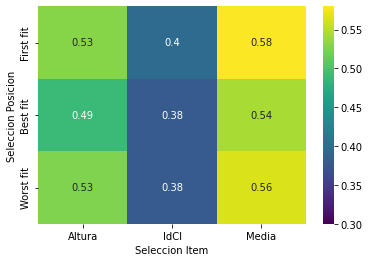

In [64]:
mean_first_fit_h1 = statistics.mean([i[0] for i in res_fist_fit_h1])
mean_first_fit_h2 = statistics.mean([i[0] for i in res_fist_fit_h2])
mean_first_fit_h3 = statistics.mean([i[0] for i in res_fist_fit_h3])

mean_best_fit_h1 = statistics.mean([i[0] for i in rest_best_fit_h1])
mean_best_fit_h2 = statistics.mean([i[0] for i in rest_best_fit_h2])
mean_best_fit_h3 = statistics.mean([i[0] for i in rest_best_fit_h3])

mean_worst_fit_h1 = statistics.mean([i[0] for i in res_worst_fit_h1])
mean_worst_fit_h2 = statistics.mean([i[0] for i in res_worst_fit_h2])
mean_worst_fit_h3 = statistics.mean([i[0] for i in res_worst_fit_h3])

medias = [[mean_first_fit_h1,mean_first_fit_h2,mean_first_fit_h3],[mean_best_fit_h1,mean_best_fit_h2,mean_best_fit_h3],
         [mean_worst_fit_h1,mean_worst_fit_h2,mean_worst_fit_h3]]

sns.heatmap(medias, annot=True,cmap="viridis",vmax=0.58,vmin=0.3)

plt.xlabel("Seleccion Item")
column_labels = ["Altura", "IdCl", "Media"] 
plt.xticks(np.arange(3) + 0.5, column_labels)

plt.ylabel("Seleccion Posicion")
row_labels = ["First fit", "Best fit", "Worst fit"] 
plt.yticks(np.arange(3) + 0.5, row_labels)

plt.show()

Se muestra el tiempo de ejecución global medio para todos los tamaños atendiento al tipo de heurística usado.

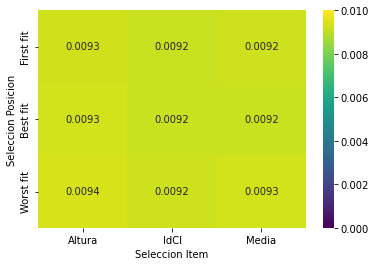

In [62]:
mean_first_fit_h1 = statistics.mean([i[0] for i in res_fist_fit_h1_t])
mean_first_fit_h2 = statistics.mean([i[0] for i in res_fist_fit_h2_t])
mean_first_fit_h3 = statistics.mean([i[0] for i in res_fist_fit_h3_t])

mean_best_fit_h1 = statistics.mean([i[0] for i in rest_best_fit_h1_t])
mean_best_fit_h2 = statistics.mean([i[0] for i in rest_best_fit_h2_t])
mean_best_fit_h3 = statistics.mean([i[0] for i in rest_best_fit_h3_t])

mean_worst_fit_h1 = statistics.mean([i[0] for i in res_worst_fit_h1_t])
mean_worst_fit_h2 = statistics.mean([i[0] for i in res_worst_fit_h2_t])
mean_worst_fit_h3 = statistics.mean([i[0] for i in res_worst_fit_h3_t])

medias = [[mean_first_fit_h1,mean_first_fit_h2,mean_first_fit_h3],[mean_best_fit_h1,mean_best_fit_h2,mean_best_fit_h3],
         [mean_worst_fit_h1,mean_worst_fit_h2,mean_worst_fit_h3]]

sns.heatmap(medias, annot=True,vmax=0.01,vmin=0.0,cmap="viridis")

plt.xlabel("Seleccion Item")
column_labels = ["Altura", "IdCl", "Media"] 
plt.xticks(np.arange(3) + 0.5, column_labels)

plt.ylabel("Seleccion Posicion")
row_labels = ["First fit", "Best fit", "Worst fit"] 
plt.yticks(np.arange(3) + 0.5, row_labels)

plt.show()

Por último, se estudia el tiempo de ejecución por tamaño de la entrada:

In [ ]:
tiempos = []
tamaños = [20,40,60,80,100,120,140]
semillas = [i+100 for i in range(50)]

for ta in tamaños:
    t = []
    for s in semillas:
        items = generaInstancias(ta,10,truck[0],s)
        max_h = max(items["Height"]) 
        min_h = min(items["Height"]) 
        max_cl = max(items["Supplier code"])
        min_cl = min(items["Supplier code"])
        if(max_h!=min_h):
            items["NormalizedH"] = (items["Height"]-min_h)/(max_h-min_h)
        else:
            items["NormalizedH"]=0
        if(max_cl!=min_cl):
            items["NormalizedC"] = (items["Supplier code"]-min_cl)/(max_cl-min_cl)
        else:
            items["NormalizedC"] = 1
        items["Norm"] = items["NormalizedH"] + 1-(items["NormalizedC"])
        items=items.sort_values(by=["Norm"],ascending=False).reset_index(drop=True)
        items.drop(["NormalizedH","NormalizedC","Norm"],axis=1, inplace=True)
        #print(items)
        t1 = time.time()
        sol1 = bestFit(truck,items)
        #print(sol1)
        t2 = time.time()
        t.append(t2-t1)
    #print("Fin",ta)
    tiempos.append(statistics.mean(t))
        


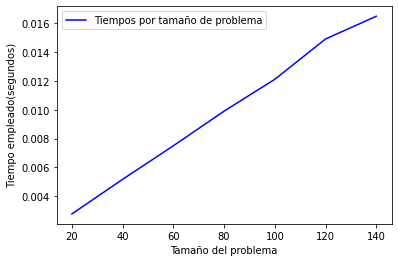

In [88]:
plt.plot(tamaños,tiempos,label='Tiempos por tamaño de problema',color="blue")

plt.legend()
plt.ylabel('Tiempo empleado(segundos)')
plt.xlabel('Tamaño del problema')

plt.show()

## Búsqueda local
En primer lugar, se estudia como afecta el número de iteraciones, fijando el parámetro randomStart a cierto, atendiendo a distintos tamaños de entrada.

In [ ]:
import statistics
semillas = [i+100 for i in range(5)]
tamaños = [20,40,60,80]
clientes = [15]
nIter = [1,2,4,6]


resIter = []
tiemposIter = []


for n in nIter:  
    for t in tamaños: 
        values = []
        times = []
        for cl in clientes:
            for s in semillas:
                
                items = generaInstancias(t,cl,truck[0],s)
                t1 = time.time()
                sol,bestValue = busquedaLocal(items,truck,randomStart=True,n_iter=n,heuristica=0)
                t2 = time.time()
                values.append(bestValue)
                times.append(t2-t1)
                print(t2-t1)
                #print("Valor",bestValue)
        resIter.append(statistics.mean
                       (values))
        tiemposIter.append(statistics.mean(times))
        #print("Tamaño",t, " iter ",n)
        #print("Media de f valor ",statistics.mean(values))
        #print("Media de tiempos ",statistics.mean(times))
    #print("Acabo ",n)
        



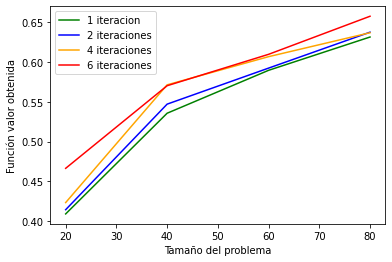

In [181]:
import matplotlib.pyplot as plt

iteraciones_1 = [0.40913950172303986,0.5355433911293396,0.5894132476883502,0.6312161292264592]
iteraciones_2 = [0.4144307973056953,0.5469523863685077,0.5921872128260522,0.6373019507100352]
iteraciones_4 = [0.42339277591513397,0.5711815205666654,0.6065527886521929,0.6366116718161554]
iteraciones_6 = [0.46638476107537385,0.5700798332867871,0.6094962938061536,0.6573019507100352]



#iteraciones_1 = resIter[0:len(resIter)]
#iteraciones_2 = resIter[len(resIter)/4:len(resIter)/2]
#iteraciones_4 = resIter[len(resIter)/2:3*len(resIter)/4]
#iteraciones_6 = resIter[3*len(resIter)/4:len(resIter)]

eje_x = [20,40,60,80]

plt.plot(eje_x,iteraciones_1,label='1 iteracion',color="green")
plt.plot(eje_x,iteraciones_2,label='2 iteraciones',color ="blue")
plt.plot(eje_x,iteraciones_4,label='4 iteraciones',color="orange")
plt.plot(eje_x,iteraciones_6,label='6 iteraciones',color="red")

plt.legend()
plt.ylabel('Función valor obtenida')
plt.xlabel('Tamaño del problema')

plt.show()

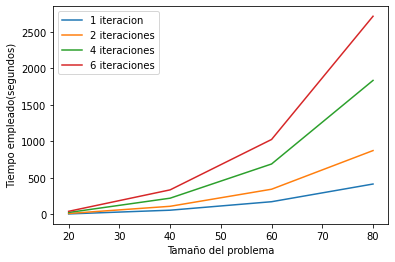

In [177]:
import matplotlib.pyplot as plt

#iteraciones_1 = tiemposIter[0:len(resIter)/4]
#iteraciones_2 = tiemposIter[len(resIter)/4:len(resIter)/2]
#iteraciones_4 = tiemposIter[len(resIter)/2:3*len(resIter)/4]
#iteraciones_6 = tiemposIter[3*len(resIter)/4:len(resIter)]

iteraciones_1 = [7.836179304122925,58.72348351478577,174.87073678970336,417.1314127922058]
iteraciones_2 = [13.819656658172608,112.18071522712708,345.9244585990906,875.0846054077149]
iteraciones_4 = [27.516121768951415,223.2246787071228,691.417168712616,1835.7452261447906]
iteraciones_6 = [43.4971688747406,337.0890697956085,1027.133882188797,2714]

eje_x = [20,40,60,80]

plt.plot(eje_x,iteraciones_1,label='1 iteracion')
plt.plot(eje_x,iteraciones_2,label='2 iteraciones')
plt.plot(eje_x,iteraciones_4,label='4 iteraciones')
plt.plot(eje_x,iteraciones_6,label='6 iteraciones')

plt.legend()
plt.ylabel('Tiempo empleado(segundos)')
plt.xlabel('Tamaño del problema')

plt.show()

### Diferencia entre informado y no informado para una iteracion

In [ ]:
import time
semillas = [i+100 for i in range(5)]
tamaños = [20,40,60,80]
clientes = [5]


valueInf = []
valueNoInf = []
tiemposInf = []
tiemposNoInf = []

for t in tamaños: 
    #print("Tamaño ",t)
    valuesI = []
    valuesNI = []
    timesInf = []
    timesNoInf = []
    for cl in clientes:
        for s in semillas:
            items = generaInstancias(t,cl,truck[0],s)
            t1 = time.time()
            sol,bestValueInf = busquedaLocal(items,truck,randomStart=True,n_iter=1,heuristica=0)
            t2 = time.time()
            sol,bestValueNoInf = busquedaLocal(items,truck,randomStart=False,n_iter=1,heuristica=0)
            t3 = time.time()
            valuesI.append(bestValueInf)
            #print("Informado ",bestValueInf)
            valuesNI.append(bestValueNoInf)
            #print("No informado",bestValueNoInf)
            timesInf.append(t2-t1)
            timesNoInf.append(t3-t2)
    valueInf.append(statistics.mean(valuesI))
    valueNoInf.append(statistics.mean(valuesNI))
    tiemposInf.append(statistics.mean(timesInf))
    tiemposNoInf.append(statistics.mean(timesNoInf))
    


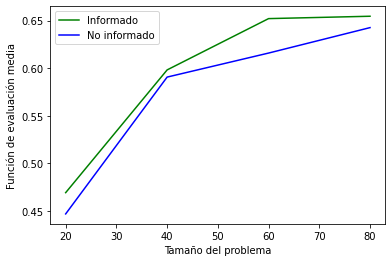

In [113]:
import matplotlib.pyplot as plt

tamaños = [20,40,60,80]

plt.plot(tamaños,valueInf,label='Informado',color="green")
plt.plot(tamaños,valueNoInf,label='No informado',color ="blue")

plt.legend()
plt.ylabel('Función de evaluación media')
plt.xlabel('Tamaño del problema')

plt.show()

In [ ]:
import statistics
semillas = [i+100 for i in range(2)]
tamaños = [20,40,60,80,100,150]
clientes = [1,2,5,10,50]
randomStart = [True, False]
nIter = [1,2,5,10]

# Resultados por cada instancia de parametros de prueba
valor_sol = []
valor_tiempo = []


##Nota añadir los tiempos
for it in nIter:
    for start in randomStart:
        for tam in tamaños:
            for cl in clientes:
                resultados = []
                tiempo_ejecucion = []
        
                for s in semillas:
                
                    items = generaInstancias(tam,cl,truck[0],s)
                    max_h = max(items["Height"]) 
                    min_h = min(items["Height"]) 
                    max_cl = max(items["Supplier code"])
                    min_cl = min(items["Supplier code"])
                    if(max_h!=min_h):
                        items["NormalizedH"] = (items["Height"]-min_h)/(max_h-min_h)
                    else:
                        items["NormalizedH"]=0
                    if(max_cl!=min_cl):
                        items["NormalizedC"] = (items["Supplier code"]-min_cl)/(max_cl-min_cl)
                    else:
                        items["NormalizedC"] = 1
                    items["Norm"] = items["NormalizedH"] + 1-(items["NormalizedC"])
                    items=items.sort_values(by=["Norm"],ascending=False).reset_index(drop=True)
                    items.drop(["NormalizedH","NormalizedC","Norm"],axis=1, inplace=True)
                    
                    
                    #Se ejecuta la busqieda local
                    sol,bestValue = busquedaLocal(items,truck,randomStart=start,n_iter=n,heuristica=0)
                    
                    resultados.append(bestValue)
                    
                    #Mido el tiempo
            
            
            

                # Para el tipo de problema se inserta media y desviacion por algoritmo
                valor_sol.append((statistics.mean(resultados),statistics.stdev(resultados)))




1) Mejora del rendimiento frente al incremento de tiempo al aumentar iteraciones según al no ser informado

In [ ]:
nIterEstudiados = valor_sol/len(nIter)

valoresPorIt = []
for i in range(len(nIterEstudiados)):
    valoresPorIt.append(valor_sol[i*len(nIterEstudiados):i*len(nIterEstudiados)+len(nIterEstudiados)])


for i in valoresPorIt:
    for j,e in enumerate(i):
        if(j%2==1):
            i.pop(j)
            
medias = [statistics.mean([e[0][0] for e in l ]) for l in valoresPorIt]
fig, ax = plt.subplots()
ax.bar(nIter, medias)

ax.set_xlabel('Column Names')
ax.set_ylabel('Values')
ax.set_title('Bar Chart')

plt.show()

2) No informado frente a informado en la primera iteracion. Como aumenta no informado segun el numero de iteraciones

In [ ]:
subproblemas  = len(clientes)*len(tamaños)
informado = []
noInformado = []
for i in range(subproblemas):
    informado.append(valor_sol[i*2])
    noInformado.append(valor_sol[i*2 + 1])

fig, ax = plt.subplots()
ax.plot(column_names,informado, label='Informado')
ax.plot(column_names,noInformado, label='No informado')
ax.set_xlabel('Column Names')
ax.set_ylabel('Values')
ax.set_title('Comparison of Line Charts')
ax.legend()
plt.show()



## Evaluación de GRASP

### Influencia del parametro randomfactor

Se estudian los resultados del parámetro usando los valores 1, 2, 3, 5 y 30

In [ ]:
randomf = [1,2,3,5,30]
cl = [3]
semillas = [i+100 for i in range(15)]

fValor = []
for rf in randomf:
    #print("Estoy en ",rf)
    valores = []
    for c in cl:
        for s in semillas:
            items = generaInstancias(45,10,truck[0],s)
            max_h = max(items["Height"]) 
            min_h = min(items["Height"]) 
            max_cl = max(items["Supplier code"])
            min_cl = min(items["Supplier code"])
            if(max_h!=min_h):
                items["NormalizedH"] = (items["Height"]-min_h)/(max_h-min_h)
            else:
                items["NormalizedH"]=0
            if(max_cl!=min_cl):
                items["NormalizedC"] = (items["Supplier code"]-min_cl)/(max_cl-min_cl)
            else:
                items["NormalizedC"] = 1
            items["Norm"] = items["NormalizedH"] + 1-(items["NormalizedC"])
            items=items.sort_values(by=["Norm"],ascending=False).reset_index(drop=True)
            items.drop(["NormalizedH","NormalizedC","Norm"],axis=1, inplace=True)
            
            
            bestValue,sol = grasp(items,truck,rf,4,metodoSeleccion=0)
            #print(bestValue)
            valores.append(bestValue)
    fValor.append(statistics.mean(valores))
    
        

In [116]:
objetos= items.reindex(sol).reset_index(drop=True)
sol = firstFit(truck,objetos)
dibuja(truck,sol,items,1300)

(433.33,-72.51)
(-433.33,72.51)
El cliente 2.0 tiene como valor red
El cliente 6.0 tiene como valor blue
El cliente 9.0 tiene como valor orange
El cliente 4.0 tiene como valor pink
El cliente 1.0 tiene como valor green
El cliente 10.0 tiene como valor red


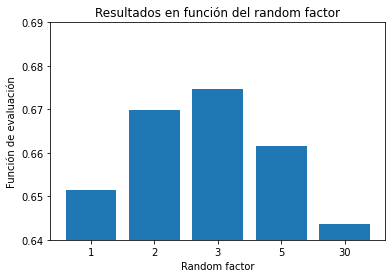

In [112]:
randomf = ["1","2","3","5","30"]
plt.bar(randomf, fValor)
plt.ylim(0.64, 0.69)
plt.title('Resultados en función del random factor')
plt.xlabel('Random factor')
plt.ylabel('Función de evaluación')
plt.show()


# Enfriamiento simulado

### Temperatura inicial y tasa de enfiramineto

Mediante una grd search, se busca la mejor combinacióin de estos parámetros

In [ ]:
semillas = [i+100 for i in range(15)]
tamaños = [80]
clientes = [10]

temp = [0.01,0.015,0.02]
alpha = [0.95,0.99,0.999]

valores = []
tiempos = []

for t_0 in temp:
    for a in alpha:
        v = []
        ti = []
        
        for t in tamaños:
            for cl in clientes:
                for s in semillas:
            
                    items = generaInstancias(45,10,truck[0],s)
                    max_h = max(items["Height"]) 
                    min_h = min(items["Height"]) 
                    max_cl = max(items["Supplier code"])
                    min_cl = min(items["Supplier code"])
                    if(max_h!=min_h):
                        items["NormalizedH"] = (items["Height"]-min_h)/(max_h-min_h)
                    else:
                        items["NormalizedH"]=0
                    if(max_cl!=min_cl):
                        items["NormalizedC"] = (items["Supplier code"]-min_cl)/(max_cl-min_cl)
                    else:
                        items["NormalizedC"] = 1
                    items["Norm"] = items["NormalizedH"] + 1-(items["NormalizedC"])
                    items=items.sort_values(by=["Norm"],ascending=False).reset_index(drop=True)
                    items.drop(["NormalizedH","NormalizedC","Norm"],axis=1, inplace=True)
                    
                    
                    
                    t1 = time.time()
                    sol,bestValue = simulated_annealing(items,truck,t_0,a,randomStart=False,heuristica=0,n_iterations=120,n_it_bucle=60)
                    t2 = time.time()
                    
                    ti.append(t2-t1)
                    #print(t2-t1)
                    v.append(bestValue)
        
        #print("Para ",t_0,"y alpha ",a,"se obtiene",statistics.mean(v))
        valores.append(statistics.mean(v))
        tiempos.append(statistics.mean(ti))

Se representa la función de evaluación:

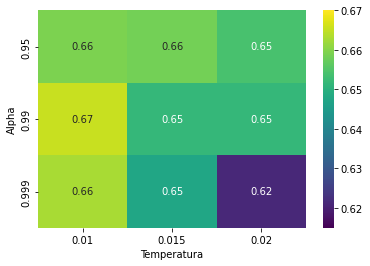

In [170]:
medias = [[valores[0],valores[3],valores[6]],[valores[1],valores[4],valores[7]],[valores[2],valores[5],valores[8]]]

temp = [0.01,0.015,0.02]
alpha = [0.95,0.99,0.999]

sns.heatmap(medias, annot=True, vmax=0.67,vmin=0.615,cmap="viridis")
plt.xlabel("Temperatura")
column_labels = ["0.01", "0.015", "0.02"] 
plt.xticks(np.arange(3) + 0.5, column_labels)

plt.ylabel("Alpha")
row_labels = ["0.95", "0.99", "0.999"] 
plt.yticks(np.arange(3) + 0.5, row_labels)

plt.show()

Ahora se buscan los tiempos en segundos por temperatura, cuyo valor para todos los casos, como es de esperar, es casi idéntico:

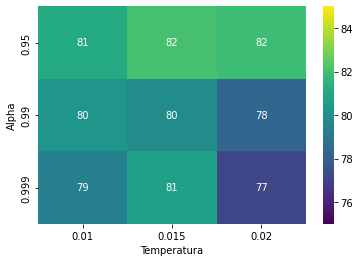

In [173]:
medias_t = [[tiempos[0],tiempos[1],tiempos[2]],[tiempos[3],tiempos[4],tiempos[5]],[tiempos[6],tiempos[7],tiempos[8]]]

sns.heatmap(medias_t, annot=True, vmax=85,vmin=75,cmap="viridis")
plt.xlabel("Temperatura")
column_labels = ["0.01", "0.015", "0.02"] 
plt.xticks(np.arange(3) + 0.5, column_labels)

plt.ylabel("Alpha")
row_labels = ["0.95", "0.99", "0.999"] 
plt.yticks(np.arange(3) + 0.5, row_labels)

plt.show()

In [ ]:
semillas = [i+100 for i in range(20)]
tamaños = [80]
clientes = [10]

temp = [0.005,0.007]
alpha = [0.99]

valores = []
tiempos = []

for t_0 in temp:
    for a in alpha:
        v = []
        ti = []
        
        for t in tamaños:
            for cl in clientes:
                for s in semillas:
            
                    items = generaInstancias(45,10,truck[0],s)
                    max_h = max(items["Height"]) 
                    min_h = min(items["Height"]) 
                    max_cl = max(items["Supplier code"])
                    min_cl = min(items["Supplier code"])
                    if(max_h!=min_h):
                        items["NormalizedH"] = (items["Height"]-min_h)/(max_h-min_h)
                    else:
                        items["NormalizedH"]=0
                    if(max_cl!=min_cl):
                        items["NormalizedC"] = (items["Supplier code"]-min_cl)/(max_cl-min_cl)
                    else:
                        items["NormalizedC"] = 1
                    items["Norm"] = items["NormalizedH"] + 1-(items["NormalizedC"])
                    items=items.sort_values(by=["Norm"],ascending=False).reset_index(drop=True)
                    items.drop(["NormalizedH","NormalizedC","Norm"],axis=1, inplace=True)
                    
                    
                    
                    t1 = time.time()
                    sol,bestValue = simulated_annealing(items,truck,t_0,a,randomStart=False,heuristica=0,n_iterations=120,n_it_bucle=60)
                    t2 = time.time()
                    
                    ti.append(t2-t1)
                    #print(t2-t1)
                    v.append(bestValue)
        
        #print("Para ",t_0,"y alpha ",a,"se obtiene",statistics.mean(v))
        valores.append(statistics.mean(v))
        tiempos.append(statistics.mean(ti))

#### Informado vs no informado

Se estudia la diferencia entre usar una heuristica para la obtención de la configuración inicial:

In [ ]:
semillas = [i+100 for i in range(20)]
tamaños = [60]
clientes = [10]

temp = [0.01]
alpha = [0.99]

valores = []
tiempos = []


for t_0 in temp:
    for a in alpha:

        
        for t in tamaños:
            vI = []
            tI = []

            vN = []
            tN = []
            for cl in clientes:
                for s in semillas:
            
                    items = generaInstancias(45,10,truck[0],s)
                    max_h = max(items["Height"]) 
                    min_h = min(items["Height"]) 
                    max_cl = max(items["Supplier code"])
                    min_cl = min(items["Supplier code"])
                    if(max_h!=min_h):
                        items["NormalizedH"] = (items["Height"]-min_h)/(max_h-min_h)
                    else:
                        items["NormalizedH"]=0
                    if(max_cl!=min_cl):
                        items["NormalizedC"] = (items["Supplier code"]-min_cl)/(max_cl-min_cl)
                    else:
                        items["NormalizedC"] = 1
                    items["Norm"] = items["NormalizedH"] + 1-(items["NormalizedC"])
                    items=items.sort_values(by=["Norm"],ascending=False).reset_index(drop=True)
                    items.drop(["NormalizedH","NormalizedC","Norm"],axis=1, inplace=True)
                    
                    
                    
                    t1 = time.time()
                    sol1,bestValue1 = simulated_annealing(items,truck,t_0,a,randomStart=False,heuristica=0,n_iterations=120,n_it_bucle=60)
                    t2 = time.time()
                    sol2,bestValue2 = simulated_annealing(items,truck,t_0,a,randomStart=True,heuristica=0,n_iterations=120,n_it_bucle=60)
                    t3 = time.time()
                    
                    #print(t2-t1)
                    tI.append(t2-t1)
                    vI.append(bestValue1)
                    
                    tN.append(t3-t2)
                    vN.append(bestValue2)
        
            #print("Informado obtiene",statistics.mean(vI))
            valores.append(statistics.mean(vI))
            tiempos.append(statistics.mean(tI))

            #print("No informado obtiene ",statistics.mean(vN))
            valores.append(statistics.mean(vN))
            tiempos.append(statistics.mean(tN))

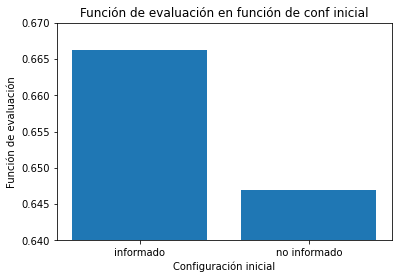

In [238]:
informado = ["informado","no informado"]
plt.bar(informado, [valores[0],valores[1]])
plt.ylim( 0.64, 0.67)
plt.title('Función de evaluación en función de conf inicial')
plt.xlabel('Configuración inicial')
plt.ylabel('Función de evaluación')
plt.show()

### Número de iteraciones

Se estudia el comportamiento del algoritmo atendiendo al número de iteraciones realizadas:

In [ ]:
semillas = [i+100 for i in range(15)]
tamaños = [80]
clientes = [10]

n_iter_ext = [0.01,0.015,0.02]
n_inter_int = [0.95,0.99,0.999]

valores = []
tiempos = []

for n_int in n_iter_ext:
    for n_ext in n_inter_int:
        v = []
        ti = []
        
        for t in tamaños:
            for cl in clientes:
                for s in semillas:
            
                    items = generaInstancias(45,10,truck[0],s)
                    max_h = max(items["Height"]) 
                    min_h = min(items["Height"]) 
                    max_cl = max(items["Supplier code"])
                    min_cl = min(items["Supplier code"])
                    if(max_h!=min_h):
                        items["NormalizedH"] = (items["Height"]-min_h)/(max_h-min_h)
                    else:
                        items["NormalizedH"]=0
                    if(max_cl!=min_cl):
                        items["NormalizedC"] = (items["Supplier code"]-min_cl)/(max_cl-min_cl)
                    else:
                        items["NormalizedC"] = 1
                    items["Norm"] = items["NormalizedH"] + 1-(items["NormalizedC"])
                    items=items.sort_values(by=["Norm"],ascending=False).reset_index(drop=True)
                    items.drop(["NormalizedH","NormalizedC","Norm"],axis=1, inplace=True)
                    
                    
                    
                    t1 = time.time()
                    sol,bestValue = simulated_annealing(items,truck,t_0,a,randomStart=False,heuristica=0,n_iterations=n_ext,n_it_bucle=n_int)
                    t2 = time.time()
                    
                    ti.append(t2-t1)
                    #print(t2-t1)
                    v.append(bestValue)
        
        #print("Para ",t_0,"y alpha ",a,"se obtiene",statistics.mean(v))
        valores.append(statistics.mean(v))
        tiempos.append(statistics.mean(ti))

## Algoritmo genético

#### Probabilidades de cruce y mutación

Se buscan las probabilidades de mutación y de cruce que se comportan mejor al problema:

In [ ]:
semillas = [i+100 for i in range(12)]
tamaños = [80]
clientes = [10]

pCruce = [0.1,0.15,0.2]
pMut = [0.95,0.965,0.98]

resT = []
resV = []

for pC in pCruce:
    for pM in pMut:
        valor = []
        tiempo = []
        
        for t in tamaños:
            for cl in clientes:
                for s in semillas:
                    t1 = time.time()
                    items = generaInstancias(t,cl,truck[0],s)
                    sol,v = algoritmo_genetico(items,truck,p_mutacion=pM,p_cruce=pC,n_iteracciones=80, tam_poblacion=90,informada=False,heuristica=0,n_elems_cruce=5,tipoCruce=1,tipoSeleccion=0)
                    t2 = time.time()
                    
                    valor.append(v)
                    tiempo.append(t2-t1)
                    #print(v)
                    #print(t2-t1)
        
        #print("para pC ",pC," y pm ",pM)
        #print("Tiempo ",statistics.mean(tiempo))
        #print("Valor ",statistics.mean(valor))
        
        resT.append(statistics.mean(valor))
        resV.append(statistics.mean(tiempo))
        
                    


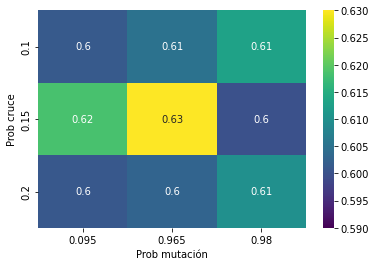

In [209]:
medias_val = [[resT[0],resT[1],resT[2]],[resT[3],resT[4],resT[5]],[resT[6],resT[7],resT[8]]]

sns.heatmap(medias_val, annot=True, vmax=0.63,vmin=0.59,cmap="viridis")
plt.xlabel("Prob mutación")
column_labels = ["0.095", "0.965", "0.98"] 
plt.xticks(np.arange(3) + 0.5, column_labels)

plt.ylabel("Prob cruce")
row_labels = ["0.1", "0.15", "0.2"] 
plt.yticks(np.arange(3) + 0.5, row_labels)

plt.show()

### Tamaño de la población

Se comprueba como se comporta el algoritmo haciendo uso de tamaños de población de 50, 75 y100

In [ ]:
semillas = [i+100 for i in range(10)]
tamaños = [80]
clientes = [10]

tamPob = [50,75,100]

resT = []
resV = []

for p in tamPob:
    ti = []
    v = []
    for t in tamaños:
        for c in clientes:
            for s in semillas:
                t1 = time.time()
                items = generaInstancias(t,cl,truck[0],s)
                sol,val = algoritmo_genetico(items,truck,p_mutacion=0.965,p_cruce=0.1,n_iteracciones=80, tam_poblacion=p,informada=True,heuristica=0,n_elems_cruce=5,tipoCruce=1,tipoSeleccion=0)
                t2 = time.time()
                ti.append(t2-t1)
                v.append(val)
                #print(t1-t2)
                #print(val)
    #print("Fin de tamaño ",p)
    resT.append(statistics.mean(ti))
    resV.append(statistics.mean(v))


Resultados de la función de evaluación:

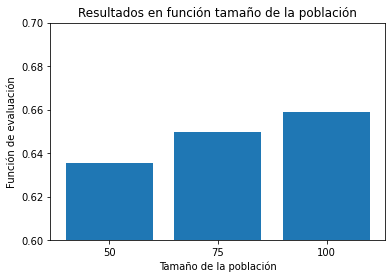

In [225]:
tam_poblacion = ["50","75","100"]
plt.bar(tam_poblacion, resV)
plt.ylim(0.60, 0.70)
plt.title('Resultados en función tamaño de la población')
plt.xlabel('Tamaño de la población')
plt.ylabel('Función de evaluación')
plt.show()

Estudio del tiempo de ejecución:

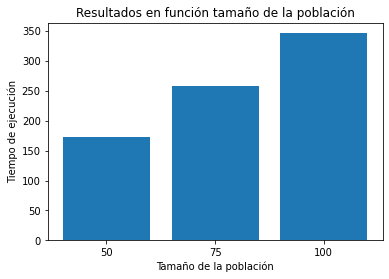

In [223]:
tam_poblacion = ["50","75","100"]
plt.bar(tam_poblacion, resT)

plt.title('Resultados en función tamaño de la población')
plt.xlabel('Tamaño de la población')
plt.ylabel('Tiempo de ejecución')
plt.show()

### Compatariva de operador de cruce

Se compara los resultados obtenidos por los operadores de cruce 2PCX y OX1

In [ ]:
semillas = [i+100 for i in range(10)]
tamaños = [80]
clientes = [10]

tamPob = [50,75,100]

resT = []
resV = []

for p in tamPob:
    ti1 = []
    v1 = []
    
    ti2 = []
    v2 = []
    for t in tamaños:
        for c in clientes:
            for s in semillas:
                items = generaInstancias(t,cl,truck[0],s)
                
                t1 = time.time()
                sol,val = algoritmo_genetico(items,truck,p_mutacion=0.965,p_cruce=0.1,n_iteracciones=80, tam_poblacion=70,informada=True,heuristica=0,n_elems_cruce=5,tipoCruce=0,tipoSeleccion=0)
                t2 = time.time()
                sol2,val2 = algoritmo_genetico(items,truck,p_mutacion=0.965,p_cruce=0.1,n_iteracciones=80, tam_poblacion=70,informada=True,heuristica=0,n_elems_cruce=5,tipoCruce=1,tipoSeleccion=0)
                t3 = time.time()
                
                ti1.append(t2-t1)
                v1.append(val)
                
                ti2.append(t3-t2)
                v1.append(val2)
                #print(t1-t2)
                #print(val)
                #print(t3-t2)
                #print(val2)
                #print("Fin de semilla ",s)
    resT.append(statistics.mean(ti1))
    resV.append(statistics.mean(v1))
    resT.append(statistics.mean(ti2))
    resV.append(statistics.mean(v2))
    #print("OP1",resV[0])
    #print("OPT1",resT[0])
    #print("OP2",resV[1])
    #print("OPT2",resT[1])

In [285]:
op1 = statistics.mean([0.6188913014157398,0.6296942591253558,0.6697817099090485,0.5867081834011777,0.651074988536448,0.6646247226952348,0.6728406550211983,0.6603586904581978,0.6324125640504605])
op2 = statistics.mean([0.5919008951732215,0.6392286947927057,0.664326590770308,0.5651532911964949,0.6453758365741615,0.6646247226952348,0.7051500786299174,0.6387962103156214,0.6365134877630827])

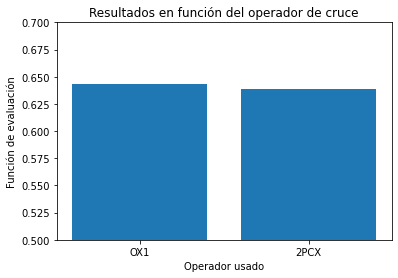

In [289]:
tam_poblacion = ["OX1","2PCX"]
res = [op1,op2]
plt.bar(tam_poblacion, res)

plt.title('Resultados en función del operador de cruce')
plt.xlabel('Operador usado')
plt.ylabel('Función de evaluación')
plt.ylim(0.5, 0.7)
plt.show()

## Comparativa global entre algoritmos

Primero se obtienen los datos de GRASP y del algoritmo de búsqueda local, para un conjunto de instancias fijas.

In [ ]:
semillas = [i+100 for i in range(10)]
tamaños = [20,40,80,120]
clientes = [10]

valLocal = []
tLocal = []

valG = []
tLocal = []

for t in tamaños:
    #print("Voor por tam ",t)
    for cl in clientes:
        vL = []
        tL = []
        
        vG = []
        tG = []
        for s in semillas:
            
            items = generaInstancias(t,cl,truck[0],s)
            max_h = max(items["Height"]) 
            min_h = min(items["Height"]) 
            max_cl = max(items["Supplier code"])
            min_cl = min(items["Supplier code"])
            if(max_h!=min_h):
                items["NormalizedH"] = (items["Height"]-min_h)/(max_h-min_h)
            else:
                items["NormalizedH"]=0
            if(max_cl!=min_cl):
                items["NormalizedC"] = (items["Supplier code"]-min_cl)/(max_cl-min_cl)
            else:
                items["NormalizedC"] = 1
            items["Norm"] = items["NormalizedH"] + 1-(items["NormalizedC"])
            items=items.sort_values(by=["Norm"],ascending=False).reset_index(drop=True)
            items.drop(["NormalizedH","NormalizedC","Norm"],axis=1, inplace=True)
            
            t1 = time.time()
            sol,bestValue = busquedaLocal(items,truck,randomStart=False,n_iter=1,heuristica=0)
            
            t2 = time.time()
            bestValue2,sol2 = grasp(items,truck,3,3,metodoSeleccion=0)
            t3 = time.time()
            #print("BL",bestValue)
            #print("GRASP",bestValue2)
            vL.append(bestValue)
            tL.append(t2-t1)
            #print("BL T",(t2-t1))
            vG.append(bestValue2)
            tG.append(t3-t2)
            #print("GRASP T",(t3-t2))
        
        valLocal.append(statistics.mean(vL))
        tLocal.append(statistics.mean(tL))
        
        valG.append(statistics.mean(vG))
        tLocal.append(statistics.mean(tG))

Se hace lo mismo para el voraz y el de recocido simulado, almacenando tanto función de evaluación como el tiempo empleado para cada semilla

In [ ]:
semillas = [i+100 for i in range(10)]
tamaños = [20,40,80,120]
clientes = [10]

valVoraz = []
tVoraz = []

valSA = []
tiSA = []

for t in tamaños:
    print("Voor por tam ",t)
    for cl in clientes:
        vSA = []
        tSA = []
        
        vVo = []
        tVo = []
        for s in semillas:
            
            items = generaInstancias(t,cl,truck[0],s)
            max_h = max(items["Height"]) 
            min_h = min(items["Height"]) 
            max_cl = max(items["Supplier code"])
            min_cl = min(items["Supplier code"])
            if(max_h!=min_h):
                items["NormalizedH"] = (items["Height"]-min_h)/(max_h-min_h)
            else:
                items["NormalizedH"]=0
            if(max_cl!=min_cl):
                items["NormalizedC"] = (items["Supplier code"]-min_cl)/(max_cl-min_cl)
            else:
                items["NormalizedC"] = 1
            items["Norm"] = items["NormalizedH"] + 1-(items["NormalizedC"])
            items=items.sort_values(by=["Norm"],ascending=False).reset_index(drop=True)
            items.drop(["NormalizedH","NormalizedC","Norm"],axis=1, inplace=True)
            
            t1 = time.time()
            sol = bestFit(truck,items)
            best_value = funcionValor(sol,truck,items)
            #print("Se produce un best values de ",best_value)
            t2 = time.time()
            sol2,bestValue2 = simulated_annealing(items,truck,0.01,0.99,randomStart=True,heuristica=0,n_iterations=120,n_it_bucle=90)
            t3 = time.time()
            #print("Voraz ",best_value)
            #print("SA",bestValue2)
            vVo.append(best_value)
            tVo.append(t2-t1)
            #print("Voraz T",(t2-t1))
            vSA.append(bestValue2)
            tSA.append(t3-t2)
            #print("SA T",(t3-t2))
        
        valVoraz.append(statistics.mean(vVo))
        tVoraz.append(statistics.mean(tVo))
        
        valSA.append(statistics.mean(vSA))
        tiSA.append(statistics.mean(tSA))

Por último, para las mismas entradas, se ejecuta el genético y se almacena sus resultados de la misma forma

In [ ]:
semillas = [i+100 for i in range(10)]
tamaños = [20,40,80,120]
clientes = [10]

vGenetic = []
tGenetic = []
sols = []
for t in tamaños:
    print("Voor por tam ",t)
    for cl in clientes:
        v = []
        ti = []
        for s in semillas:
            items = generaInstancias(t,cl,truck[0],s)
            t1 = time.time()
            sol,val = algoritmo_genetico(items,truck,p_mutacion=0.965,p_cruce=0.1,n_iteracciones=80, tam_poblacion=p,informada=True,heuristica=0,n_elems_cruce=5,tipoCruce=1,tipoSeleccion=0)
            t2 = time.time()
            
            ti.append(t2-t1)
            print(t1-t2)
            print(val)
            v.append(val)
            sols.append(sol)
        print("Media para tamaño",t,"es de",statistics.mean(v))
        vGenetic.append(statistics.mean(v))
        tGenetic.append(statistics.mean(ti))
            

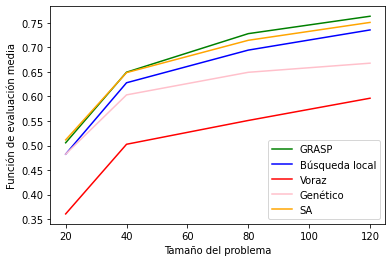

In [281]:
import matplotlib.pyplot as plt

tamaños = [20,40,80,120]

plt.plot(tamaños,valG,label='GRASP',color="green")
plt.plot(tamaños,valLocal,label='Búsqueda local',color ="blue")
plt.plot(tamaños,valVoraz,label='Voraz',color ="red")
plt.plot(tamaños,vGenetic,label='Genético',color ="pink")
plt.plot(tamaños,valSA,label='SA',color ="orange")

plt.legend()
plt.ylabel('Función de evaluación media')
plt.xlabel('Tamaño del problema')

plt.show()

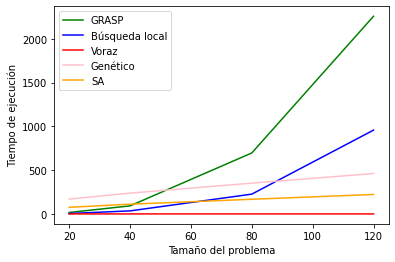

In [271]:
import matplotlib.pyplot as plt

tamaños = [20,40,80,120]

plt.plot(tamaños,tGRASP,label='GRASP',color="green")
plt.plot(tamaños,tLoca,label='Búsqueda local',color ="blue")
plt.plot(tamaños,tVoraz,label='Voraz',color ="red")
plt.plot(tamaños,tGenetic,label='Genético',color ="pink")
plt.plot(tamaños,tiSA,label='SA',color ="orange")

plt.legend()
plt.ylabel('Tiempo de ejecución')
plt.xlabel('Tamaño del problema')

plt.show()